# Generates QC reports
##### builds off mriqc statistics
* Per subject medians
* Compare relative to other datasets
* Functional reports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
from IPython.display import SVG, display

import matplotlib.patches as mpatches

%matplotlib inline

ImportError: No module named seaborn

In [2]:
af = pd.read_csv('/om/scratch/Thu/mathias/data/derivatives/mriqc/bold.csv')
abide_mriqc_func = af.ix[:, ['subject_id', 'fd_mean']]

aa = pd.read_csv('/om/scratch/Thu/mathias/data/derivatives/mriqc/T1w.csv')
abide_mriqc_anat = aa.ix[:, ['subject_id', 'cnr']]

asubjs = aa.subject_id.unique()

abide_csv = pd.read_csv('/storage/gablab001/banda/scripts/analysis/ABIDE_Phenotypic_preprocessed1.csv')
abide_compare = abide_csv[abide_csv.subject.isin(asubjs)].ix[:, ['subject', 'anat_cnr', 'func_mean_fd']].reset_index(drop=True)

abide_compare['mriqc_cnr'] = abide_mriqc_anat.cnr
abide_compare['mriqc_mean_fd'] = abide_mriqc_func.fd_mean

abide_compare = abide_compare[['subject', 'anat_cnr', 'mriqc_cnr', 'func_mean_fd', 'mriqc_mean_fd']]

FileNotFoundError: File b'/om/scratch/Thu/mathias/data/derivatives/mriqc/bold.csv' does not exist

In [7]:
mriqc_func = '/om/project/autoxy/processedData/bids/data/derivatives/mriqc/bold.csv'
mriqc_anat = '/om/project/autoxy/processedData/bids/data/derivatives/mriqc/T1w.csv'
df_func = pd.read_csv(mriqc_func)
df_anat = pd.read_csv(mriqc_anat)

# add row with all means
#df2 = df.mean()
#df2['subject_id'] = 'all'
#df2['task_id'] = 'all'
#df2['run_id'] = 'all'
#df = df.append(df2, ignore_index=True)

df_func[['run_id']] = df_func[['run_id']].fillna(value=1) # set resting run == 1
df_func['all'] = 1

subjs = df_func.subject_id.unique()
subjs = list(subjs[5:]) + list(subjs[:5])

In [8]:
# AUTOXY Specific

# task order - rest gambling face conflict
task1 = df_func[df_func.task_id == 'rest']
task2 = df_func[df_func.task_id == 'morph']
task3 = df_func[df_func.task_id == 'sholo']

all_tasks = [('rest', task1), ('morph', task2)]

task_data = {'rest': task1,
             'morph': task2}

names = {0: 'Resting', 
         1: 'Morph'}

runs_per_tasks = {'rest': 1,
                  'morph': 4}

presentation_order = ['rest', 'morph']

task1.run_id = 1 # since not in filename, defaults to NaN


task_lookup = {'rest': task1,
               'morph': task2,
               'sholo': task3}

def gen_subject_df(master_df, subj, field='subject_id', task=None):
    subj_df = master_df[master_df[field] == subj]
    if task:
        return subj_df[subj_df['task_id'] == task]
    return subj_df
    

/om/user/mathiasg/envs/py3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [81]:
def gen_boxplots(tasks_df, measures, sep='subject_id', save=False):
    """ TODO: Refactor this to heatmap """

    outpath = os.path.abspath('./qc_plots/')

    def id_outliers(data, meas, num_std = 1.5):
        # return values not within certain number of STDs
        out = []
        outliers = data[((data - data.mean()).abs() > num_std * data.std())]
        for outlier in outliers:
            subj = run_data.loc[run_data[meas] == outlier]['subject_id'].item()
            out.append((subj, outlier))
        return out

    for meas in measures:
        if sep == 'group':
            colors = 2
        else:
            colors = len(subjs) // 2
            
        cmap = sns.husl_palette(colors)
        sns.set_style("whitegrid")
        sns.set_palette(palette=cmap, n_colors=colors, desat=.75)

        fig, axes = plt.subplots(1, 2, figsize=(15,9), sharey=True) # plot all tasks in the same grid

        for i, taskinfo in enumerate(tasks_df):
            taskname, task = taskinfo
            
            if np.all(task.run_id.isnull()):
                run_id = None
                jitter = .1
            else:
                run_id = 'run_id'
                jitter = True

            sns.boxplot(x=run_id, y=meas, data=task, color='c', width=.4, ax=axes[i])
            sns.stripplot(x=run_id, y=meas, data=task, hue=sep, 
                          jitter=jitter, size=8, linewidth=1, ax=axes[i])

            axes[i].set_title(names[i])
            #axes[i].set_ylim(0, task[meas].max() + .5)
            if axes[i] != axes[0]:
                axes[i].set_ylabel('')
            
            if not run_id:
                axes[i].set_xticklabels([1])
            axes[i].legend_.remove()

            # label outliers
            for run in list(range(runs_per_tasks[taskname])):
                run_data = task.loc[task['run_id'] == run + 1]
                outliers = id_outliers(run_data[meas], meas)
                y_min, y_max = axes[i].get_ylim()
                scale = (y_max - y_min) / 50.
                for subj, val in outliers:
                    # first two runs up + left, last two runs down + right
                    axes[i].annotate(subj, xy=(run-0.5, val + scale))


        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Subjects')
        sns.despine(left=True)

        if save:
            outfile = os.path.join(outpath, '{}_per_task.png'.format(meas))
            plt.savefig(outfile)

/om/user/mathiasg/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


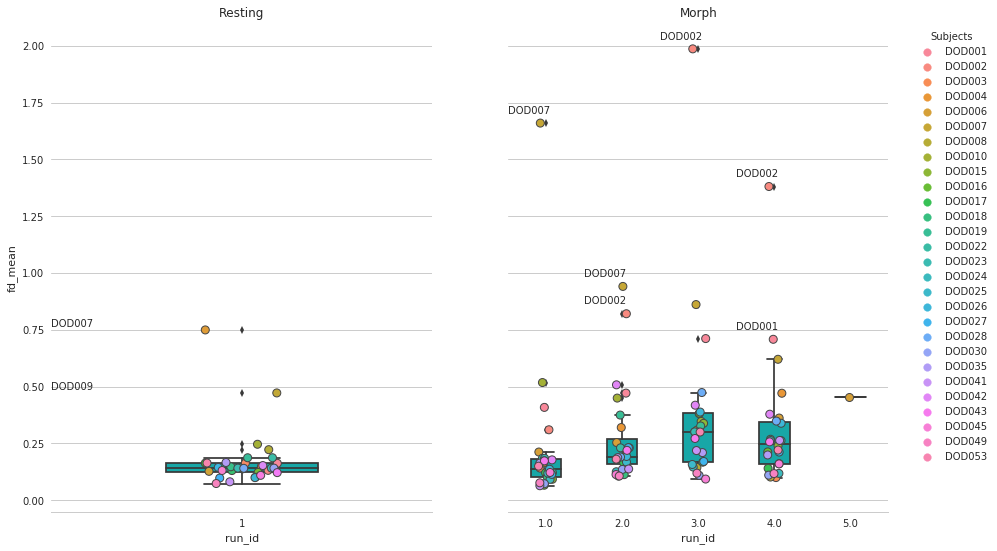

In [8]:
#gen_boxplots(all_tasks, qc_measures, sep='group', save=False)
#(all_tasks, ['fd_mean'], save=False)

In [5]:
def merge_runs(data):
    """ First we will find the average across runs for each task """
    all_subj_merged = pd.DataFrame(columns=data.columns[1:]) # drop run_id from columns
    for subj in data.subject_id.unique():
        merged_subj = pd.DataFrame(columns=data.columns[1:]) # drop run_id from columns
        subj_df = data.loc[data.subject_id == subj]
        for task in subj_df.task_id.unique():
            mean_runs = subj_df.loc[subj_df.task_id == task].mean()
            mean_runs['subject_id'] = subj
            mean_runs['task_id'] = task
            merged_subj = merged_subj.append(mean_runs, ignore_index=True)
        all_subj_merged = all_subj_merged.append(merged_subj, ignore_index=True)
    return all_subj_merged

def gen_heatmap(measures, center=None, master_df=df_func):

#     Generate heatmap with all subjects across tasks in chronological 
#     order.
    
#     XXX TODO: option for center abide dataset
    
#     Parameters
#     ----------
#     measures : list
#         List of measures to plot - one plot is generated per measure.
#     center : string, NoneType
#         If None, heatmap intensity is not centered. 
#         If 'banda', heatmap intensity is centered to the banda dataset's 
#         mean value of the measure.
#     master_df : DataFrame
#         Dataframe of MRIQC output bold.csv

    data = merge_runs(master_df)
    for measure in measures:
        # organize by presentation order
        heatdata = data.pivot("subject_id", "task_id", measure)#['rest', 'morph']
        fig, ax = plt.subplots()
        fig.set_size_inches(12,18)
        if center == 'project':
            center = master_df[measure].mean() # mean across banda dataset
    
        sns.heatmap(heatdata, annot=True, linecolor='black', center=center, 
                    linewidth='.1',cmap="OrRd") 
        ax.set_title('{} over time'.format(measure.upper()))
        ax.set_xlabel("Task ID")
        ax.set_ylabel("Subject ID")

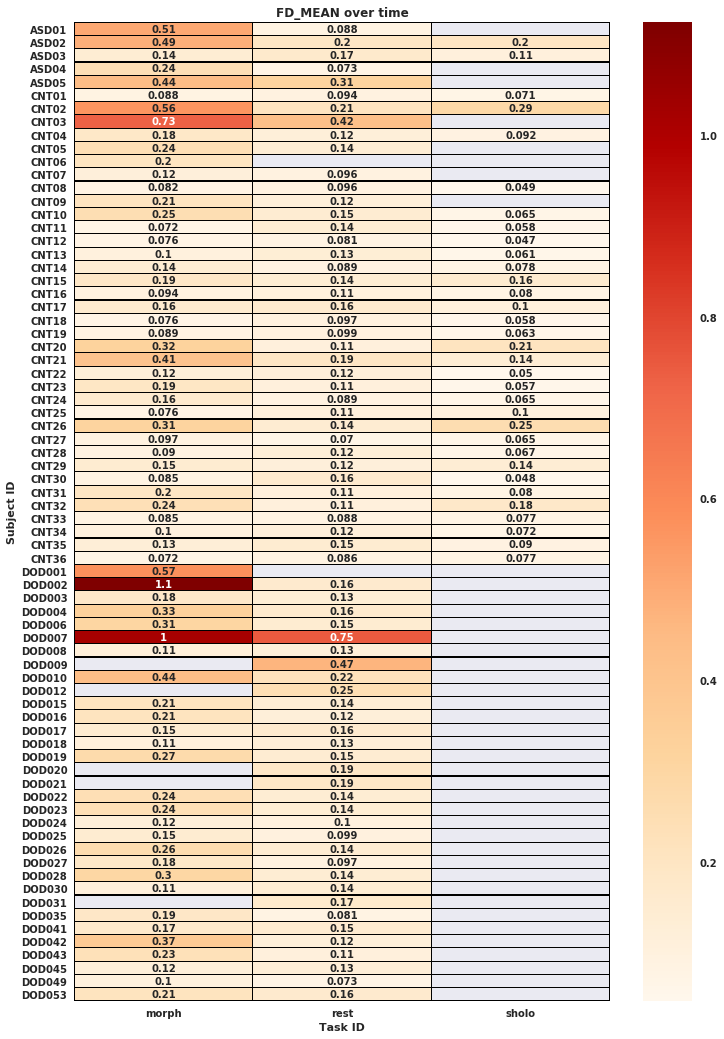

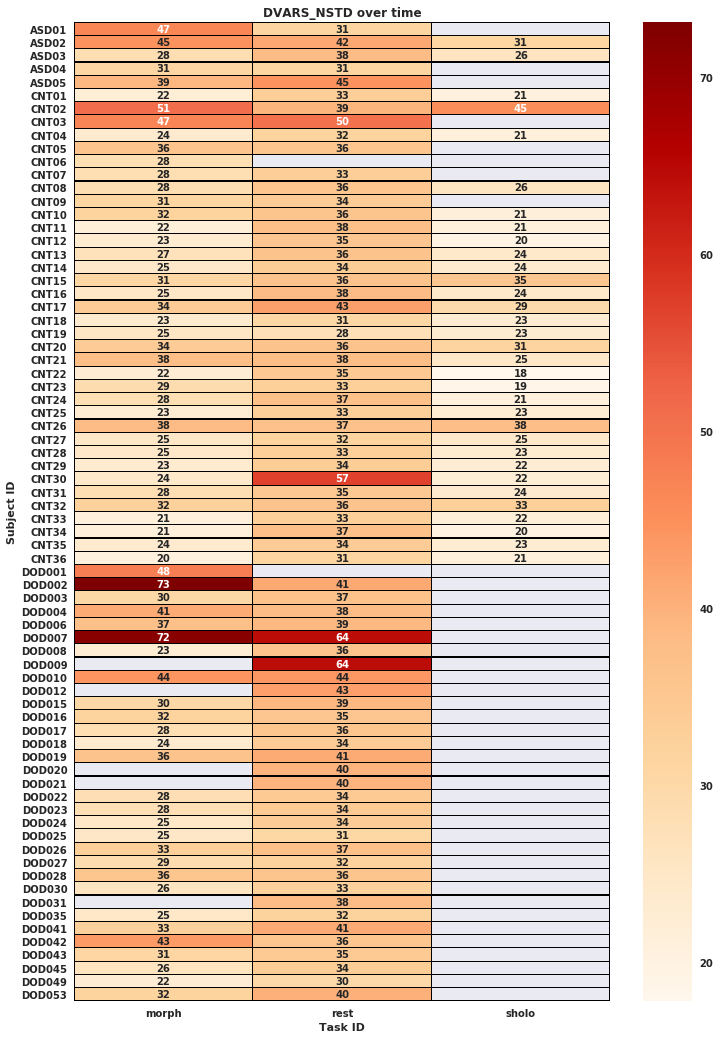

In [6]:
gen_heatmap(['fd_mean', 'dvars_nstd'])

In [47]:
def gen_boxplot_medians(subj, measures, overlay=True, master_df=df):
    """ 
    Generate a boxplot with median statistic across all runs/tasks 
    per subject. Plot with the banda distribution. 
    
    XXX TODO: Add other datasets average.
    
    Parameters
    ----------
    subj : string
        The subject name (without the sub-)
    measures : list
        List of measures to plot - one plot is generated per measure.
    overlay : boolean
        If true, plot entire banda data and subject specific
        on the same axis. If false, plot in separate axes.
    """
    for measure in measures:
        
        if overlay:
            fig, ax = plt.subplots()
            ax1, ax2 = ax, ax
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            ax2.set_xlabel("subject_id")

        sns.set(style="whitegrid")
        # average all participants
        sns.boxplot(x="all", y=measure, data=df, width=.3, 
                    color="gray", saturation=.2, ax=ax2, showfliers=False) # hide outliers

        ax2.set_xticklabels([])
        ax2.set_xlabel('all Autoxy')
        ax2.set_ylabel('')

        # subject specific 
        subj_df = df.loc[df['subject_id'] == subj]
        sns.boxplot(x="subject_id", y=measure, data=subj_df, 
                    width=.3, color='red', ax=ax1, linewidth=.5)

        ax1.set_ylabel(measure.upper())
        ax1.set_xlabel("")

In [72]:
def gen_boxplot_abide(subj, measures=['fd_mean', 'cnr'], overlay=False, 
                        abide=True, save=False, outpath=None):
    """ 
    Generate a boxplot with median statistic across all runs/tasks 
    for a given subject. Plot with the banda distribution. 
    
    XXX TODO: Add other datasets average.
    
    Parameters
    ----------
    subj : string
        The subject name (without the sub-)
    measures : list
        List of measures to plot - one plot is generated per measure.
    overlay : boolean
        If true, plot entire banda data and subject specific
        on the same axis. If false, plot in separate axes.
    """
    
    accepted_measures = ['fd_mean', 'cnr']
    
    for measure in measures:
        if measure not in accepted_measures:
            continue  
        elif measure == 'fd_mean':
            df = df_func
            lw = 2
        elif measure == 'cnr':
            df = df_anat
            lw = 5
    
        
        if overlay:
            fig, ax = plt.subplots()
            ax1, ax2 = ax, ax
        else:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            ax2.set_xlabel("subject_id")

        sns.set(style="whitegrid")
        
        # subject specific 
        subj_df = df[df['subject_id'] == subj]
        sns.boxplot(x="subject_id", y=measure, data=subj_df,
                    width=.3, color='red', ax=ax1, linewidth=lw)
        ax1.set_ylabel(measure)
        ax1.set_xlabel("")
        
        # across all BANDA
        sns.boxplot(y=measure, data=df, width=.3, showfliers=False,
                    color="gray", saturation=.2, ax=ax2)
        ax2.set_xticklabels([])
        ax2.set_xlabel('AUTOXY')
        ax2.set_ylabel('')
        
        if abide:
            # across all ABIDE
            if measure == 'fd_mean':
                measure = 'mriqc_mean_fd'
            elif measure == 'cnr':
                measure = 'mriqc_cnr'

            sns.boxplot(y=measure, data=abide_compare, width=.3,
                        color='white', saturation=.2, ax=ax3)
            sns.boxplot()
            ax3.set_xticklabels([])
            ax3.set_ylabel('')
            ax3.set_xlabel('ABIDE')
        
        if save and outpath:
            if not os.path.exists(outpath):
                os.makedirs(outpath)
                
            outfile = os.path.join(outpath, '{}_{}.png'.format(subj, measure))
            plt.savefig(outfile)

/om/user/mathiasg/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


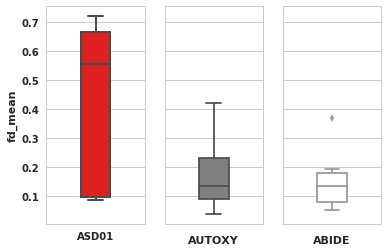

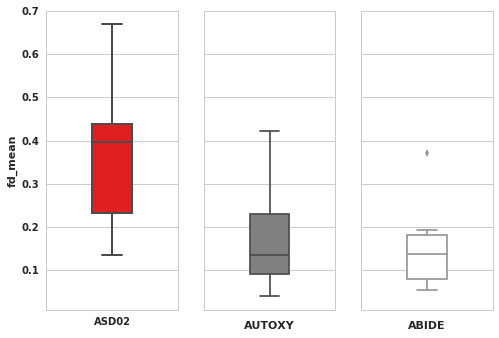

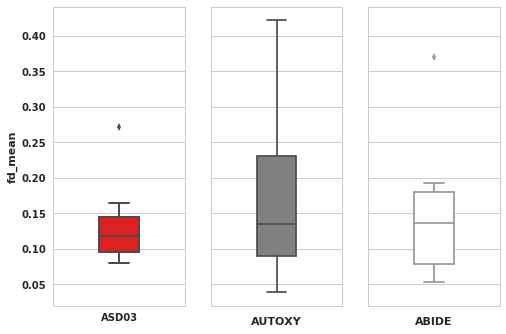

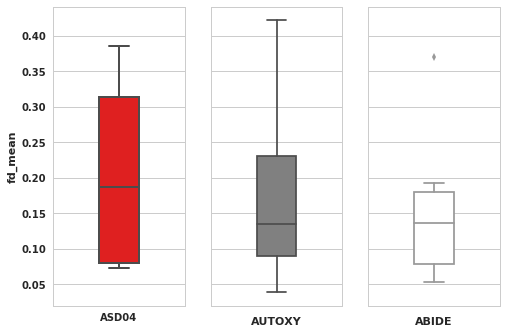

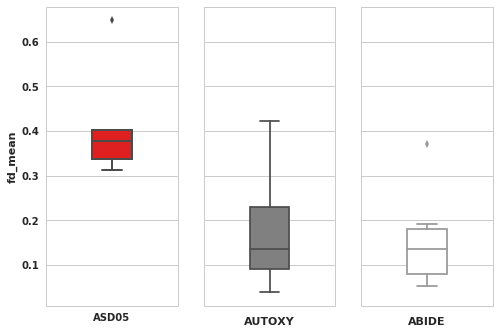

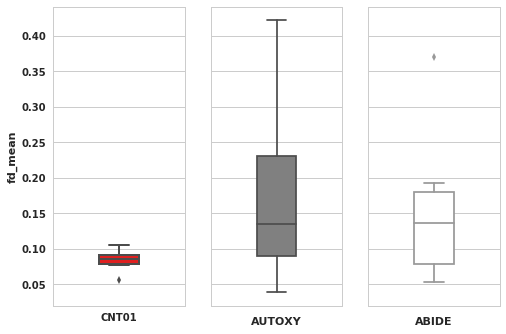

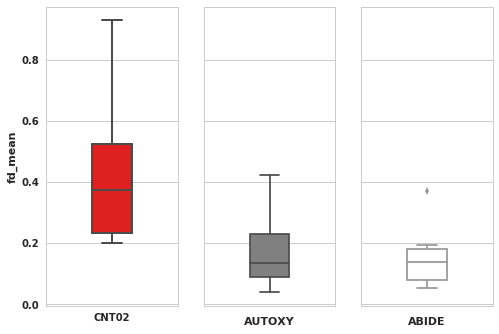

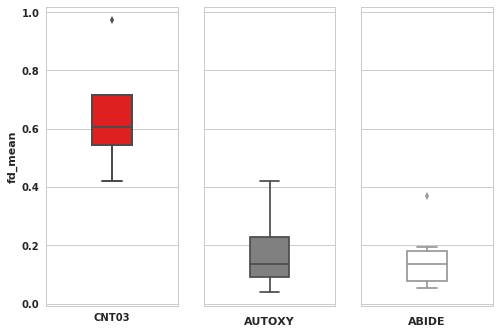

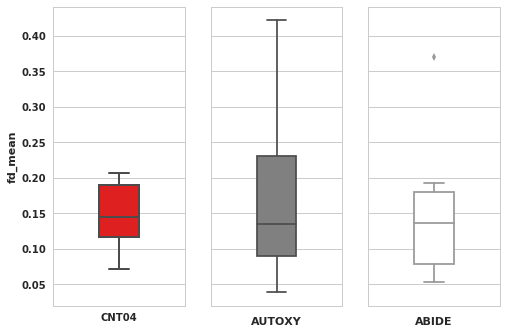

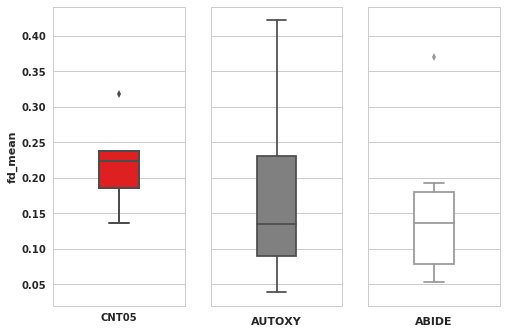

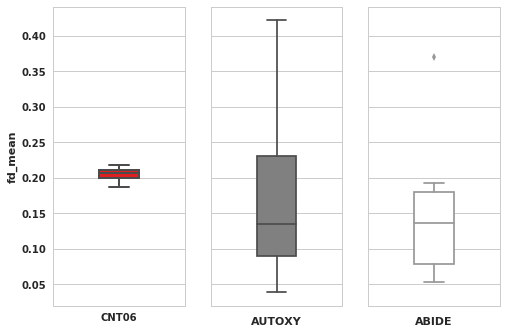

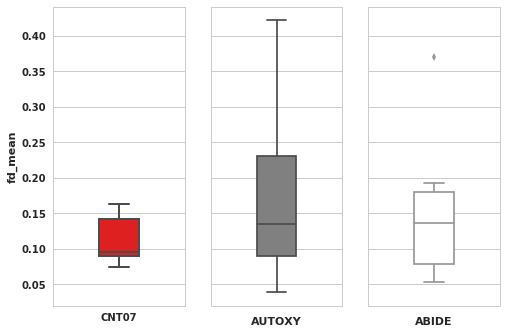

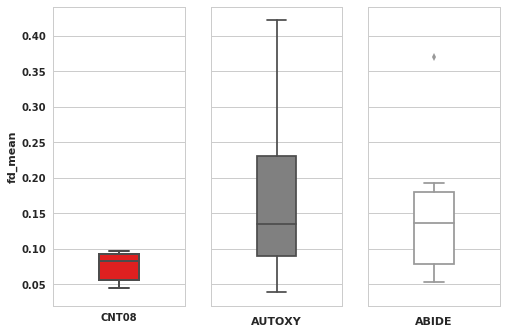

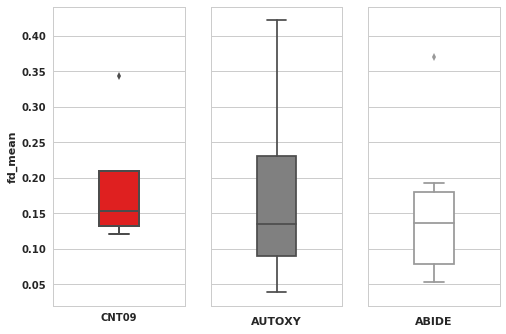

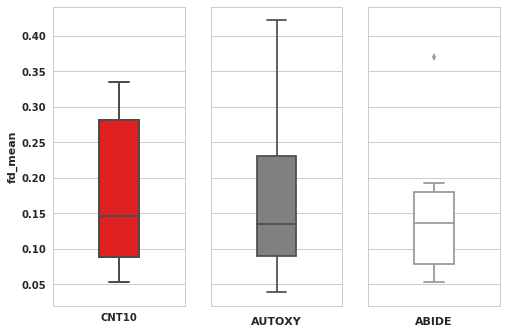

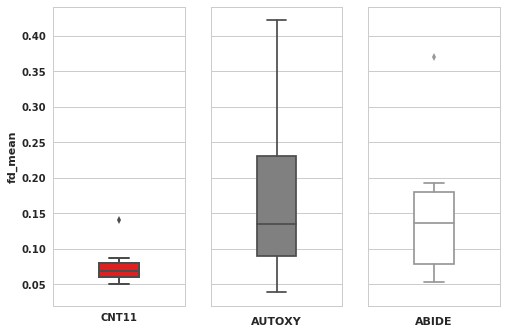

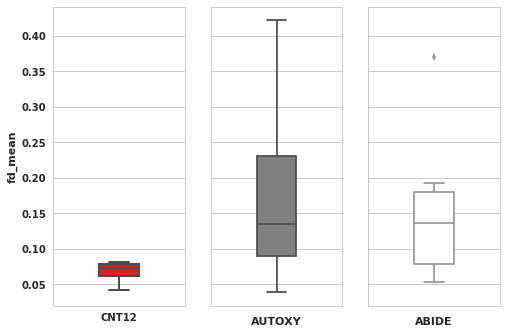

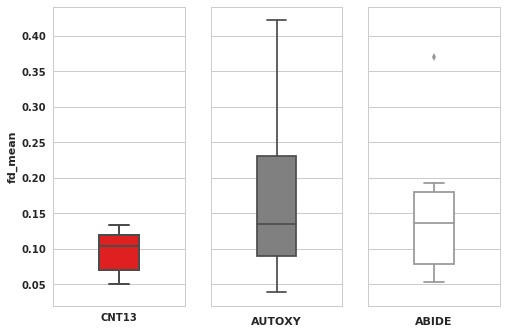

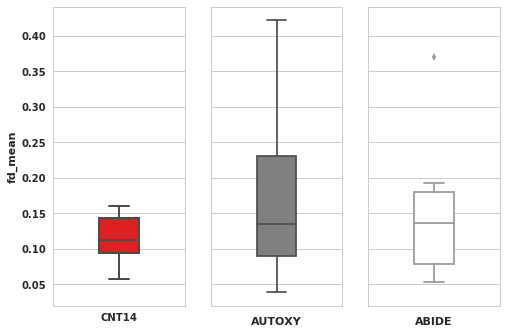

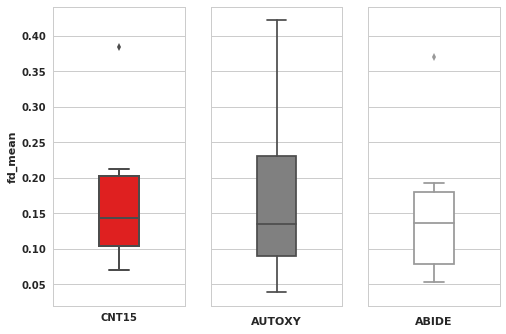

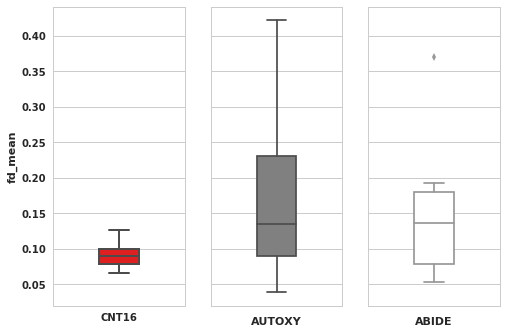

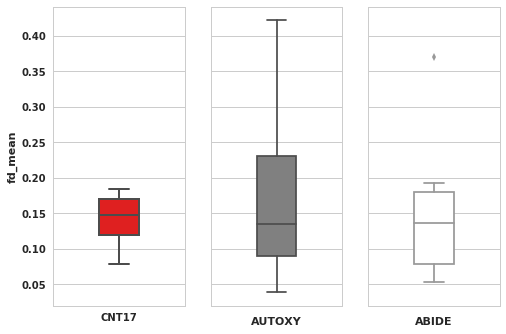

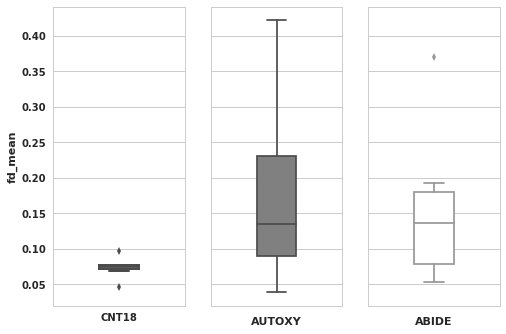

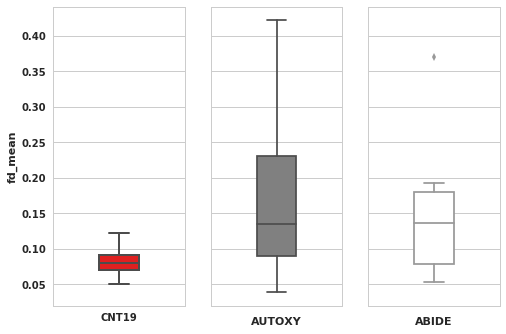

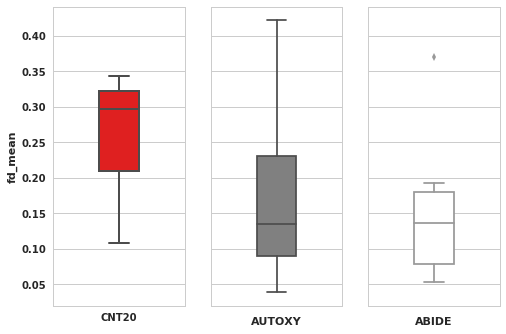

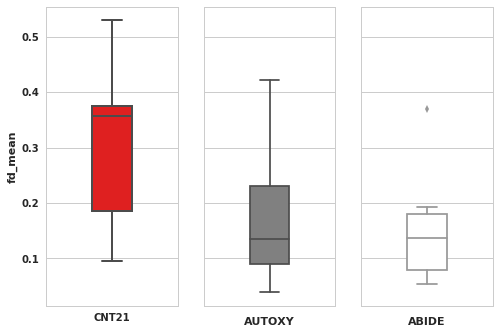

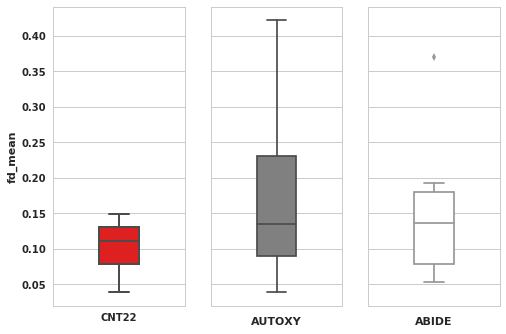

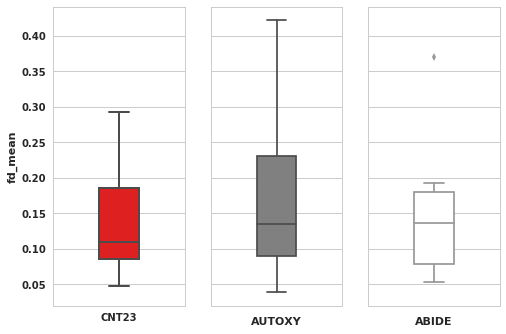

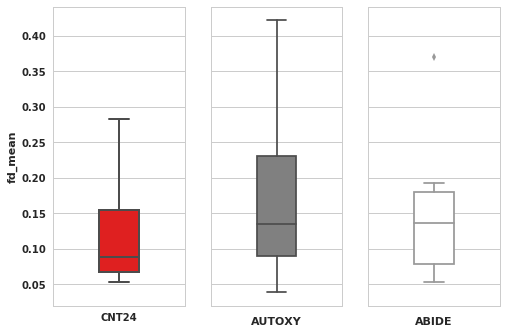

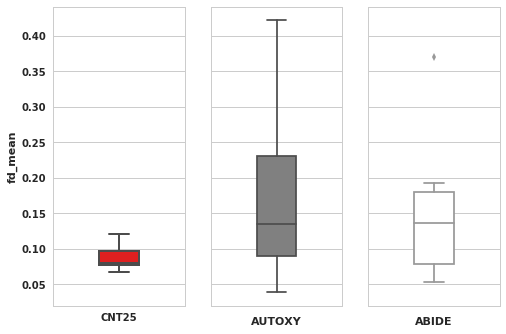

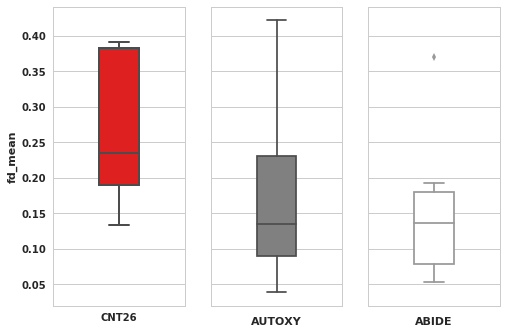

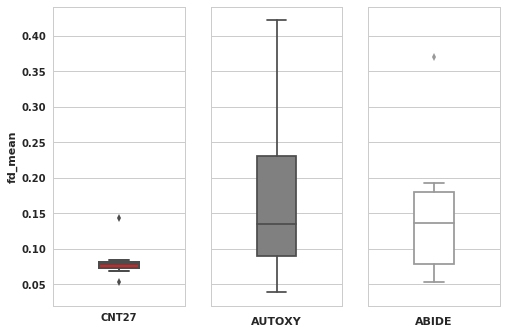

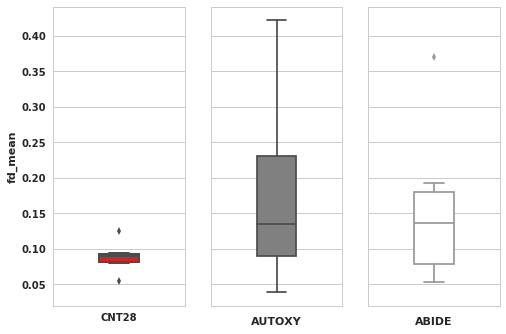

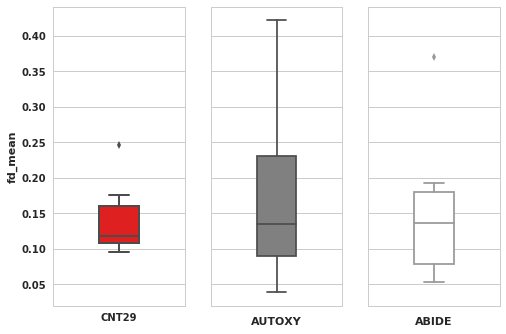

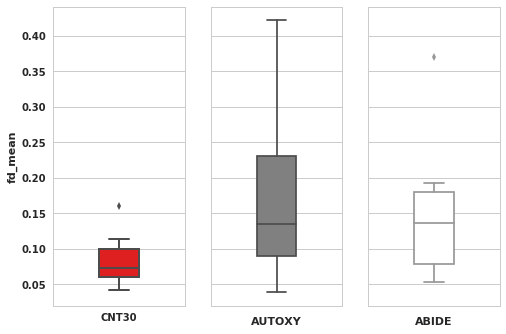

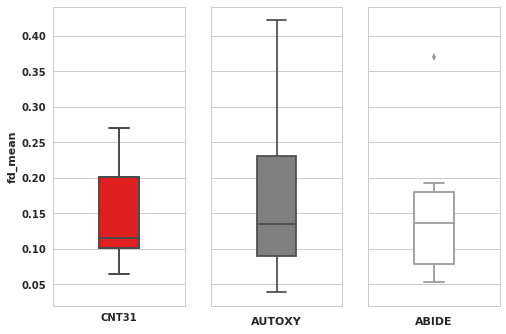

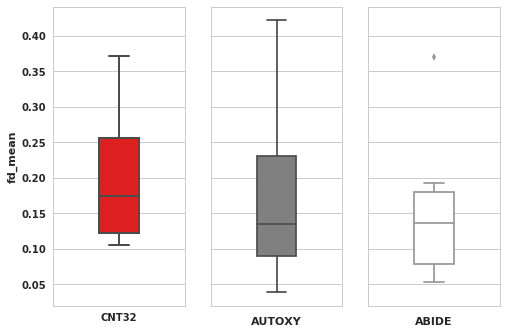

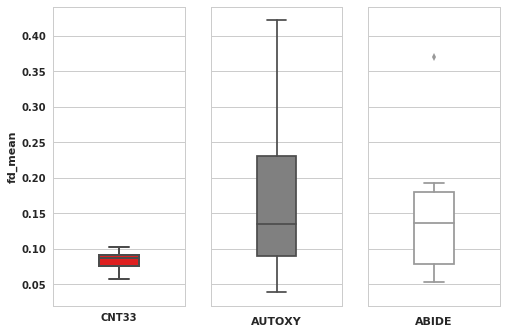

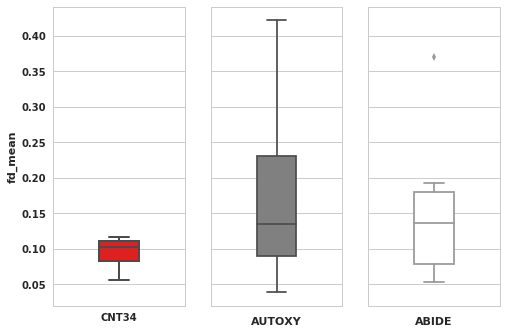

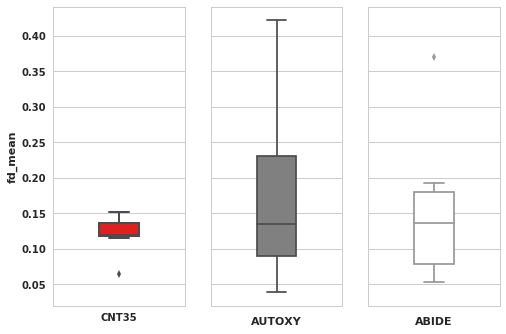

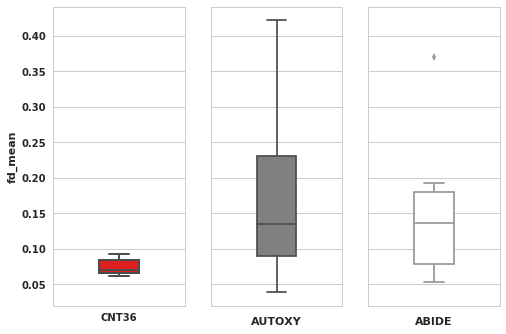

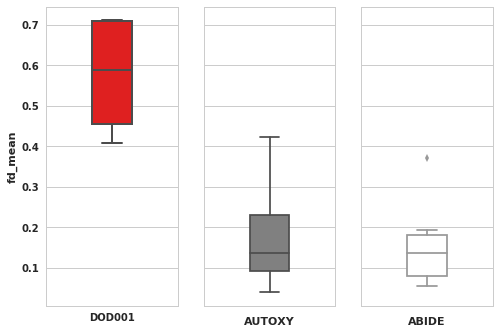

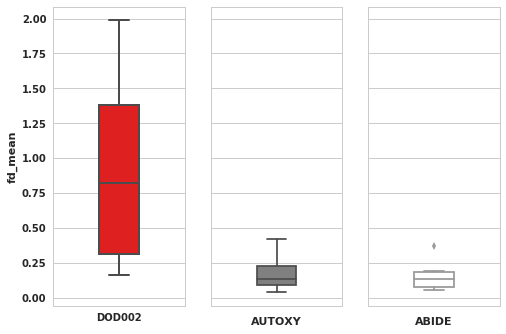

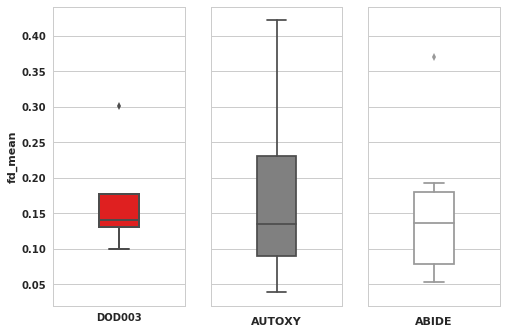

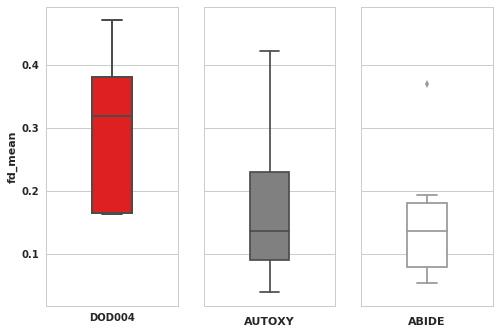

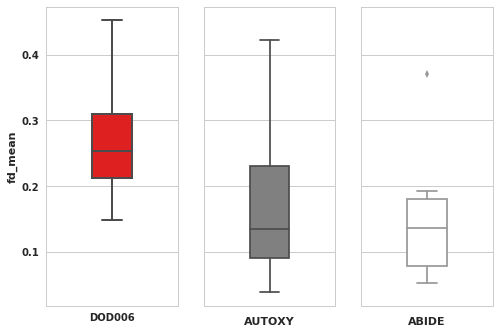

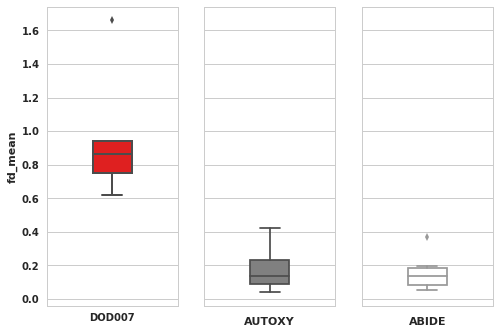

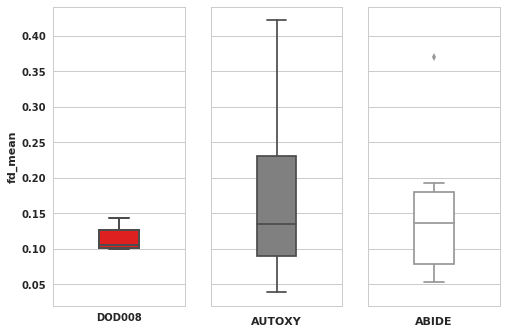

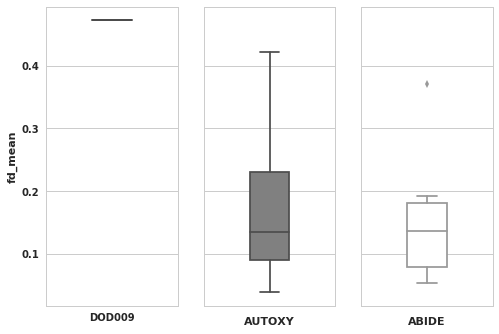

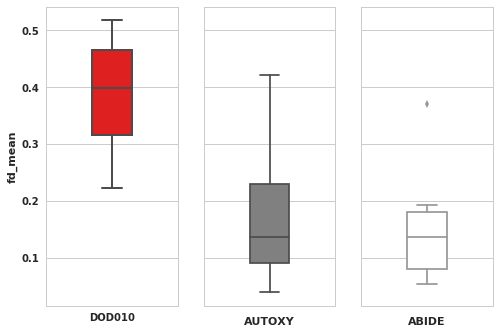

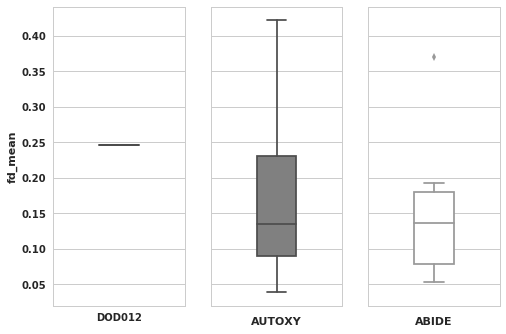

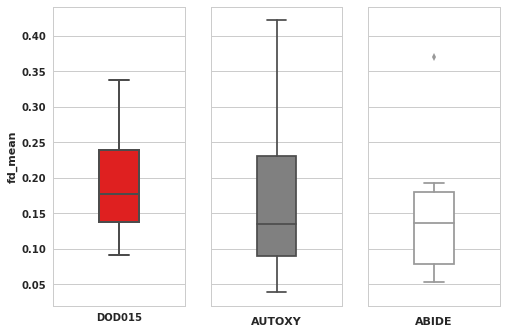

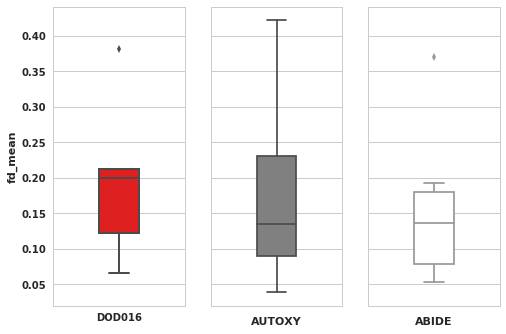

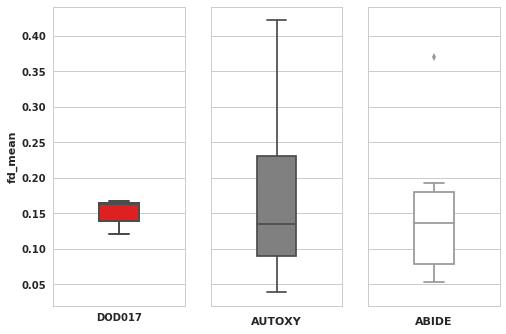

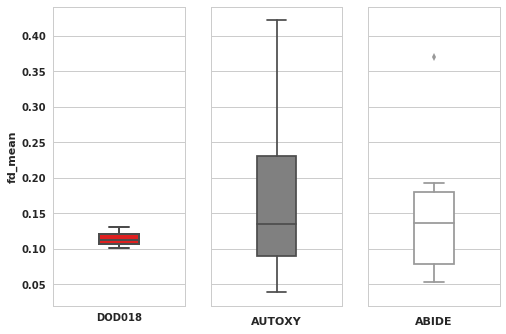

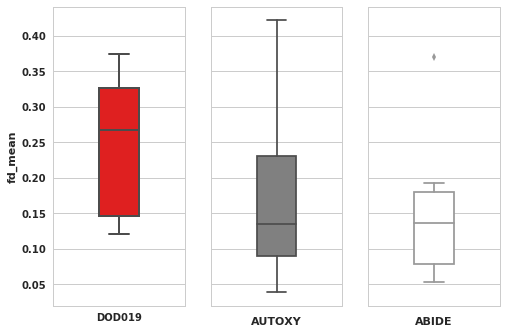

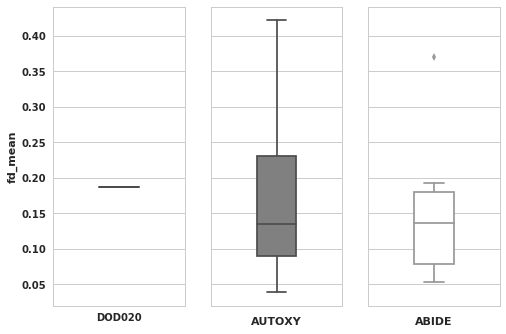

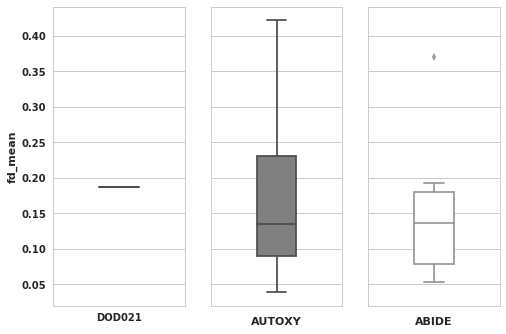

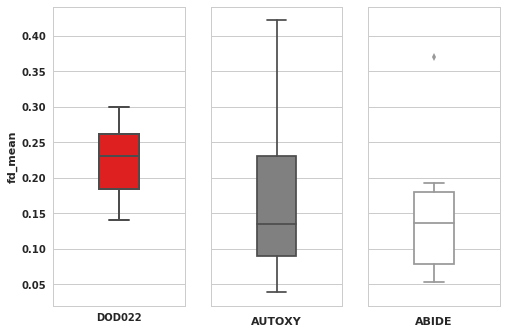

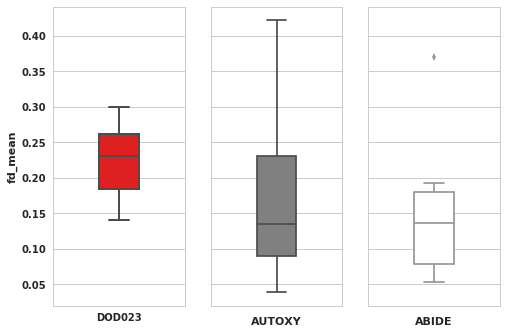

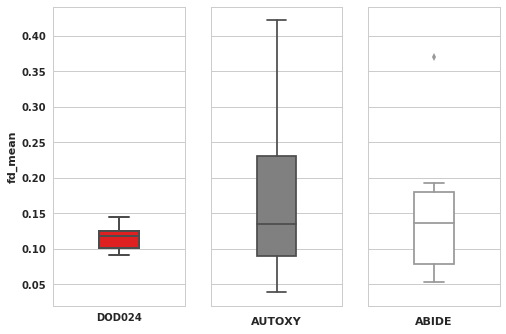

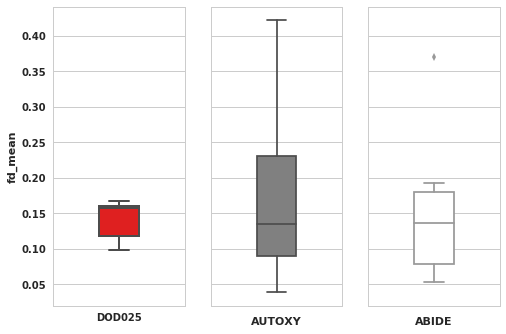

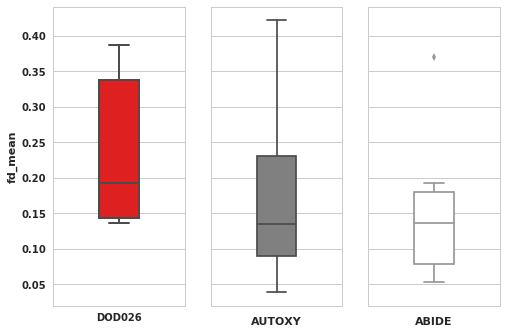

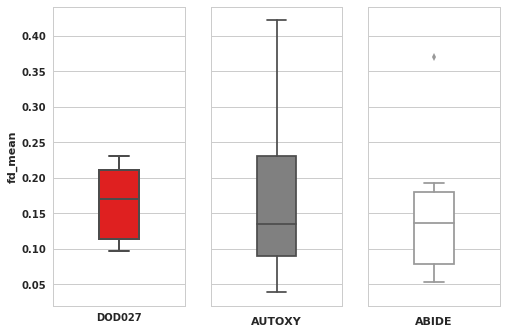

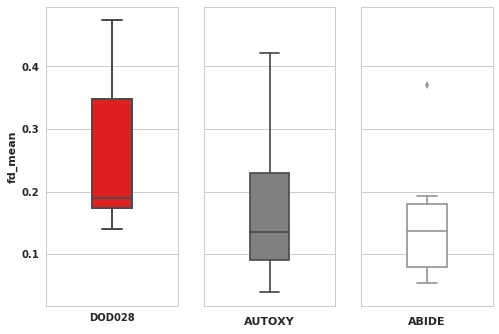

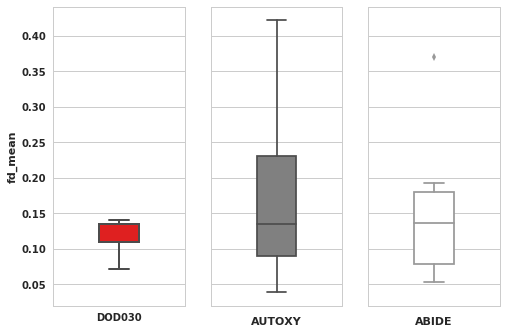

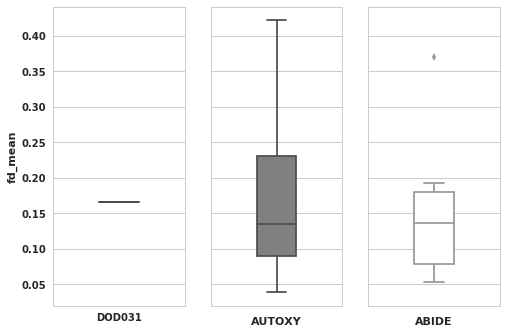

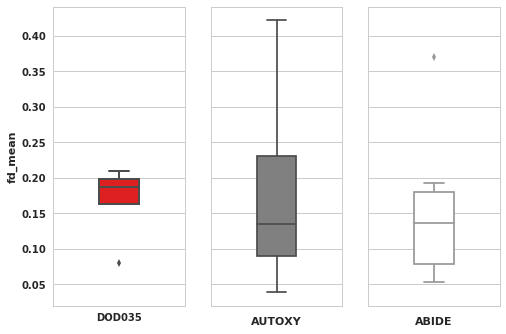

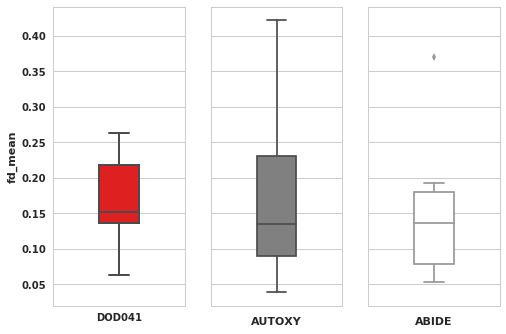

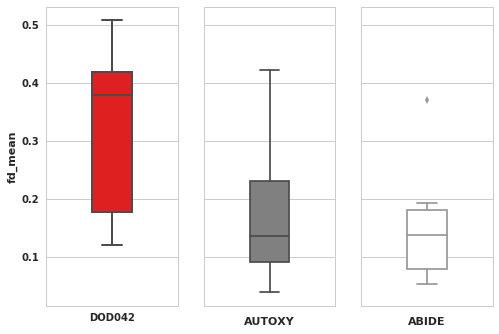

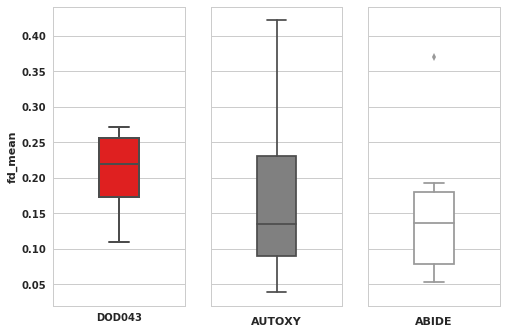

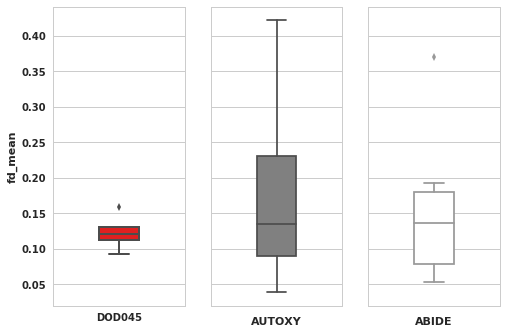

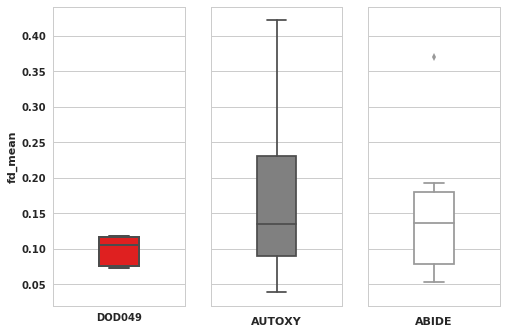

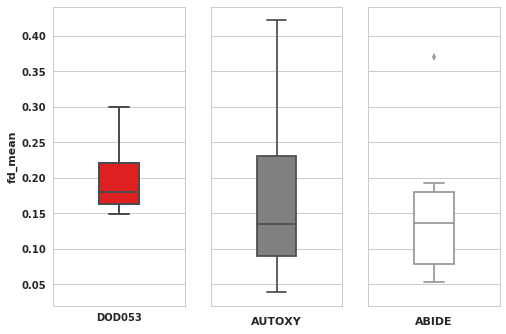

In [74]:
for subj in subjs:
    gen_boxplot_abide(subj, ['fd_mean'], overlay=False)

In [69]:
def gen_single_subj_boxplots(task, measures, subj, save=False, outpath=None):
    """ Generate per task, per subject, per measure boxplot of group average and 
    individual subject metrics. """

    for meas in measures:
            
        sns.set_style("whitegrid")

        fig, ax = plt.subplots(figsize=(10,5))

        task_df = task_lookup[task]
        
        task_df.run_id = task_df.run_id.astype(int)
        
        # boxplot of task averages
        sns.boxplot(x='run_id', y=meas, data=task_df, color='c', 
                    width=.4, showfliers=False) # hide outliers

        # now plot individual subject
        subj_task = gen_subject_df(task_df, subj)
        
        if len(subj_task) == 0:
            print('No QC data found for task-{} subject-{}.'.format(task, subj))
            return
        
        sns.stripplot(x='run_id', y=meas, data=subj_task, color='red',
                      edgecolor='white', size=10, linewidth=1)
        
        ax.set_xlabel('Run')
        ax.set_ylabel(meas.capitalize())
        ax.set_title(subj)
        plt.suptitle('Task-{}'.format(task.capitalize()))

        if save and outpath:
 
            if not os.path.exists(outpath):
                os.makedirs(outpath)

            outfile = os.path.join(outpath, '{}_{}_{}_with_runs.png'.format(subj, task, meas))
            plt.savefig(outfile)

/om/user/mathiasg/envs/py3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/om/user/mathiasg/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


No QC data found for task-morph subject-DOD009.
No QC data found for task-morph subject-DOD012.
No QC data found for task-morph subject-DOD020.
No QC data found for task-morph subject-DOD021.
No QC data found for task-morph subject-DOD031.


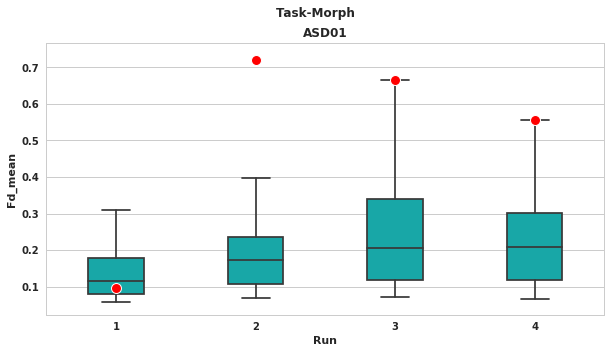

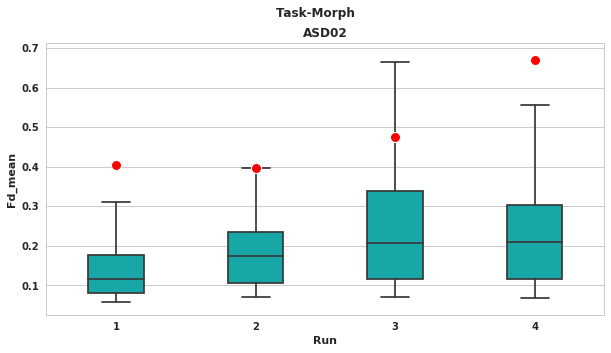

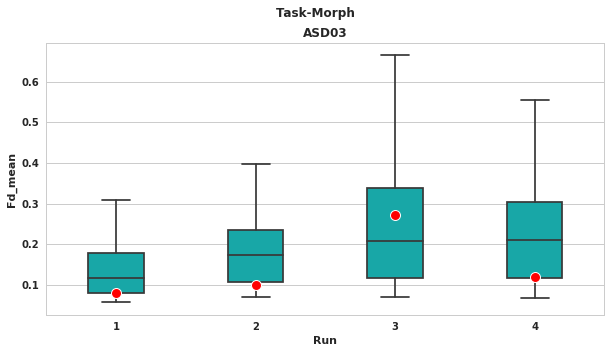

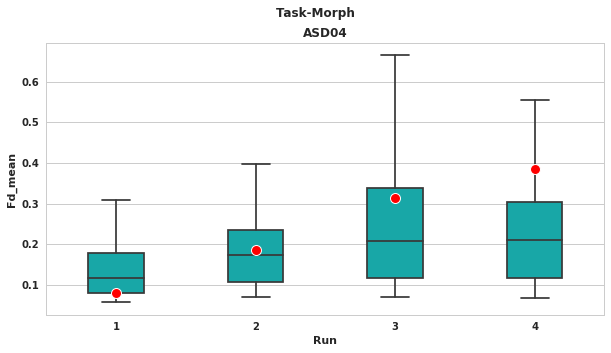

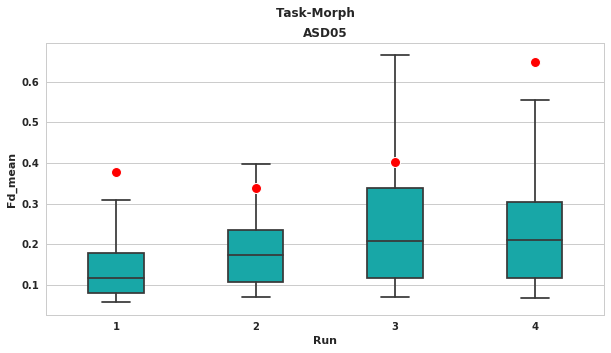

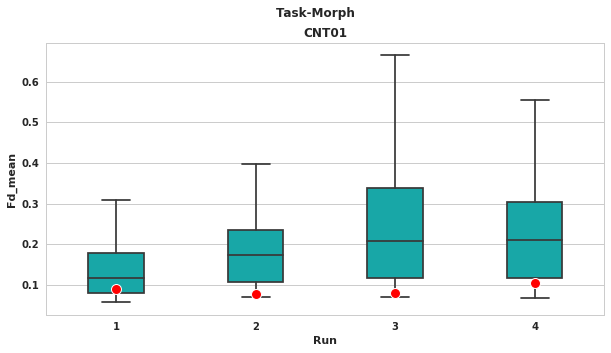

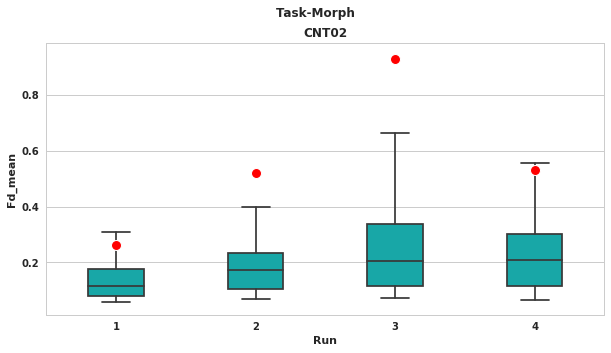

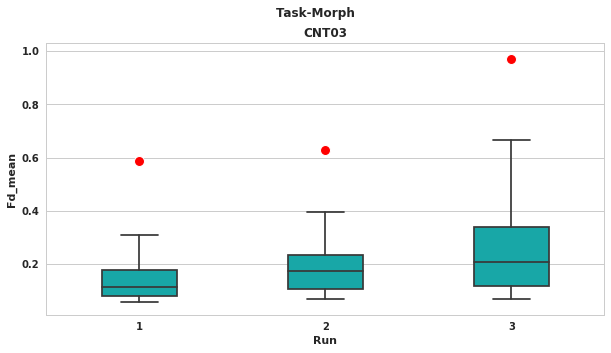

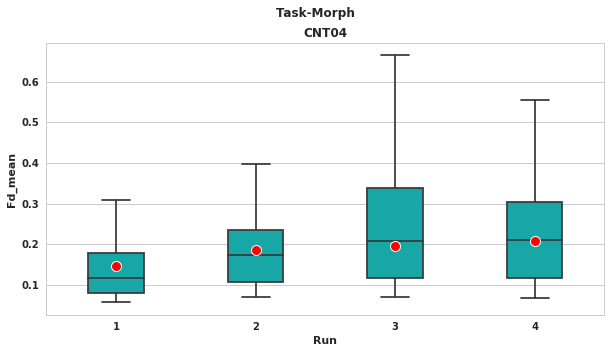

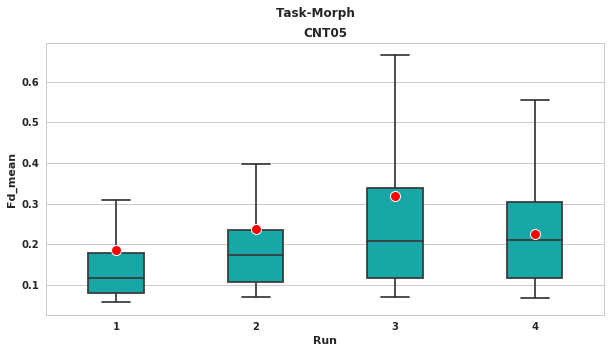

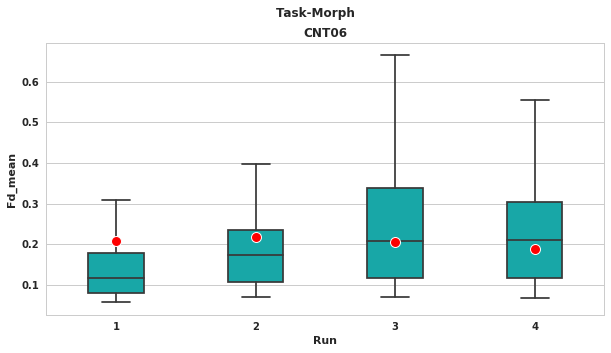

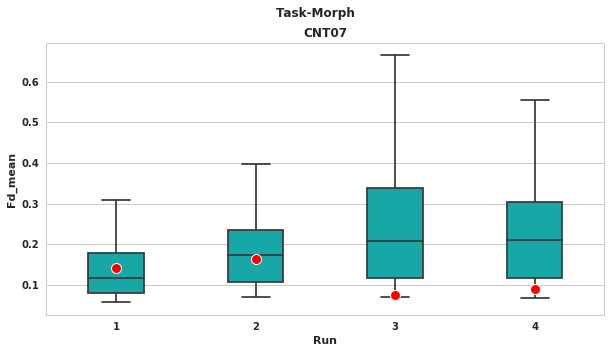

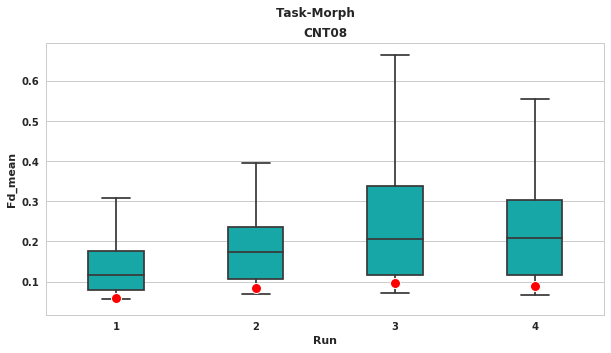

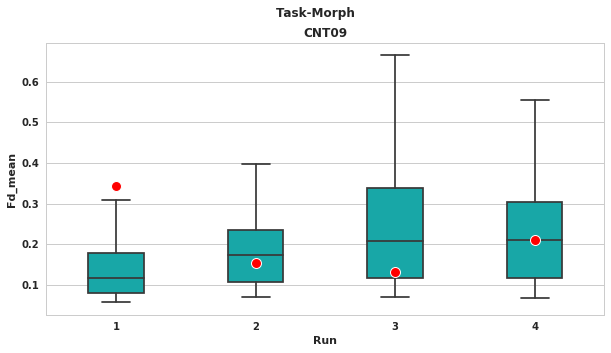

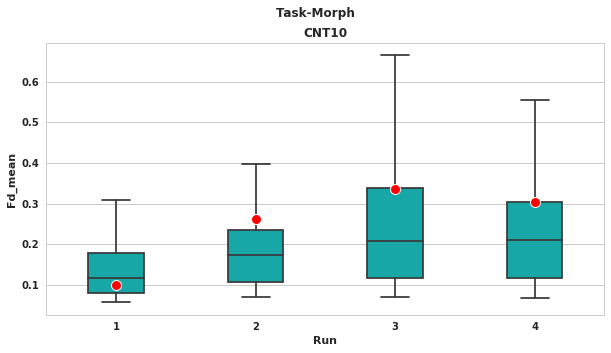

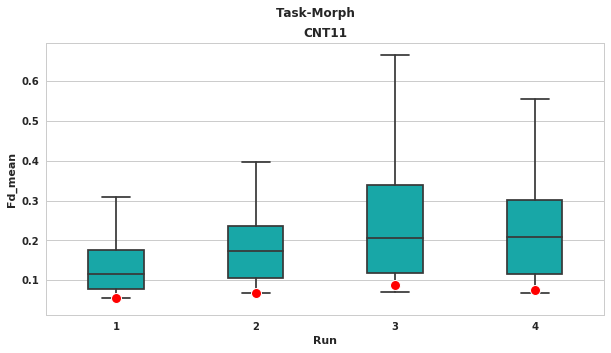

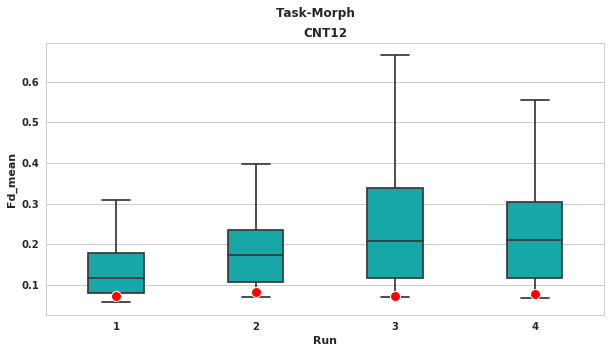

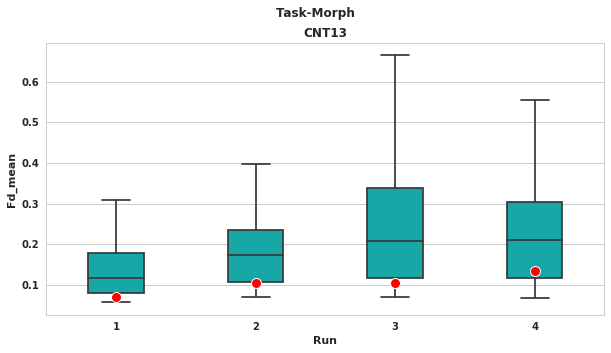

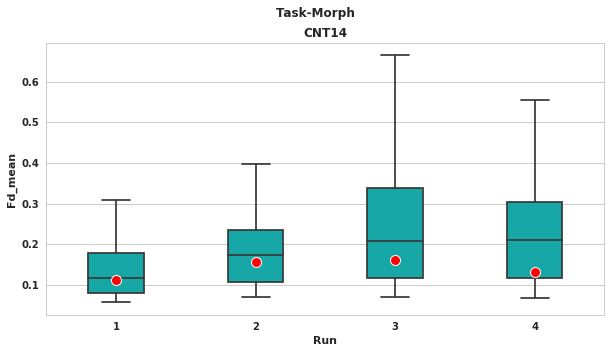

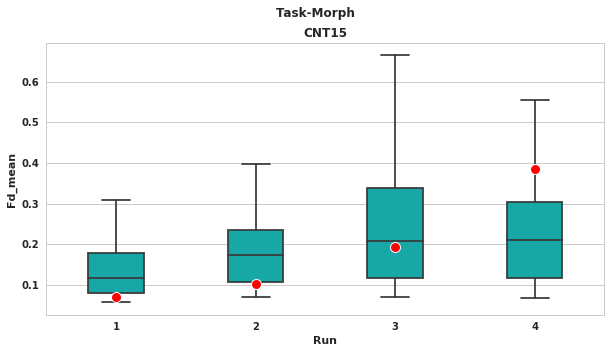

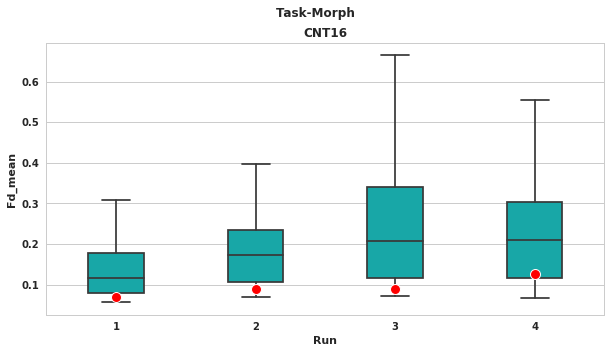

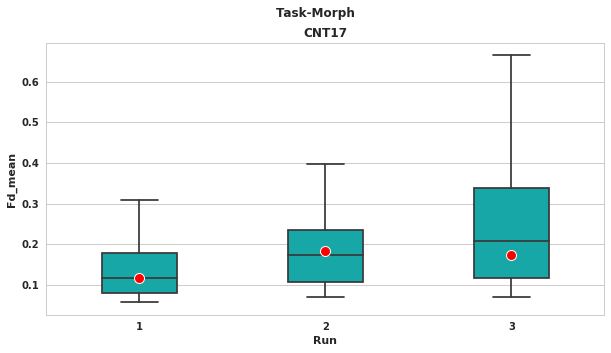

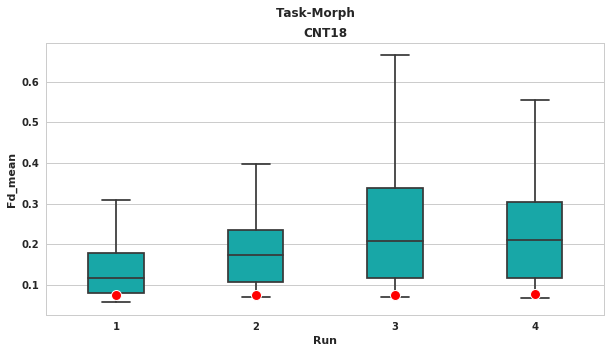

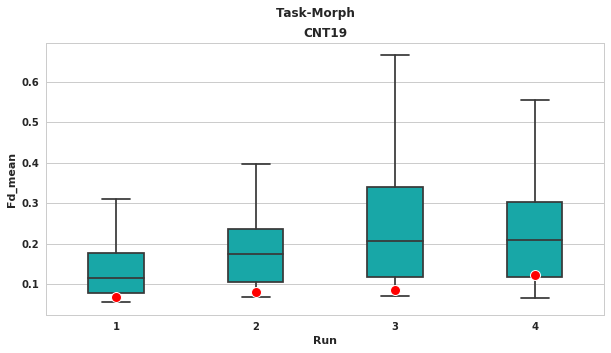

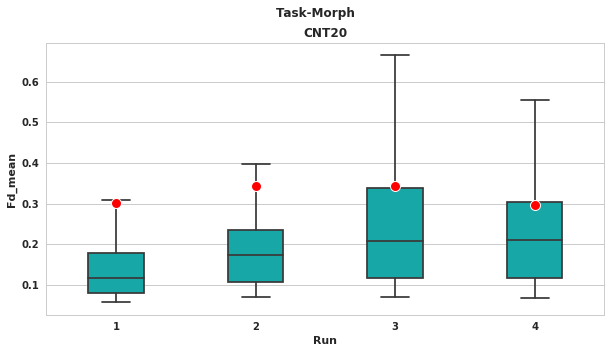

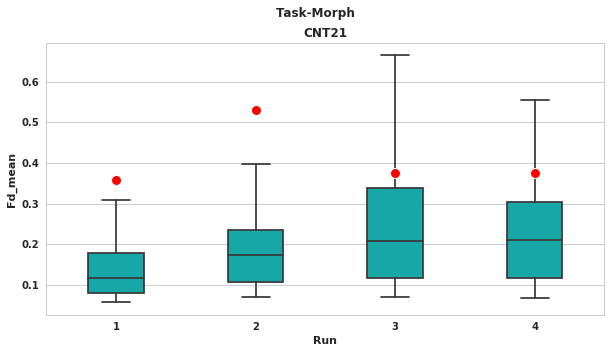

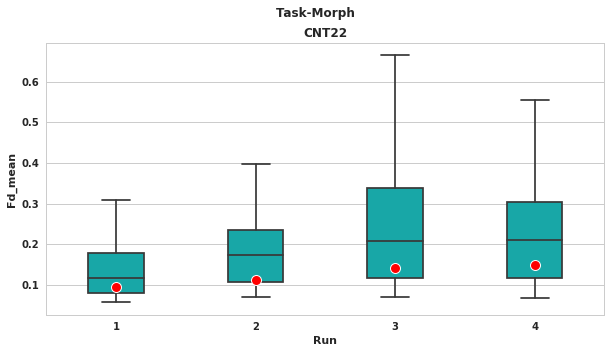

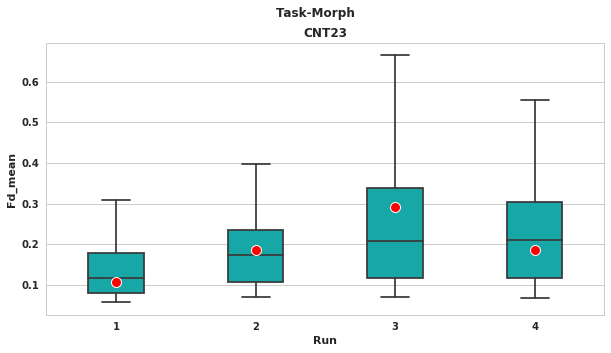

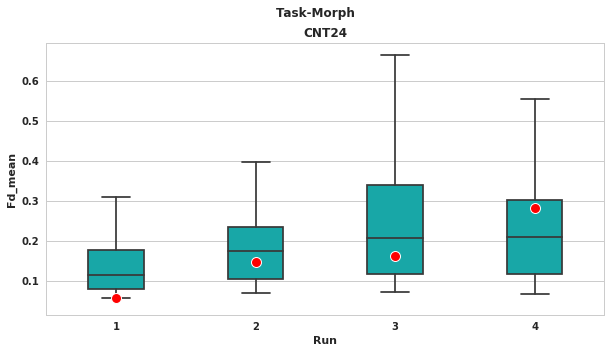

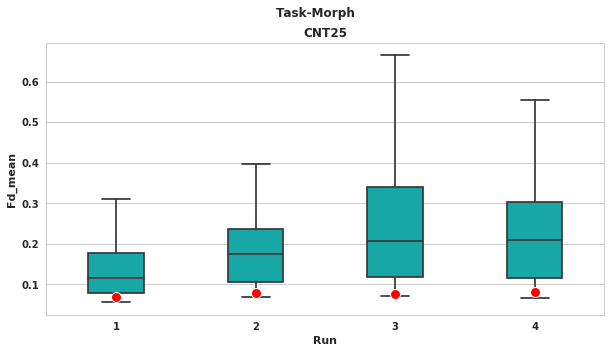

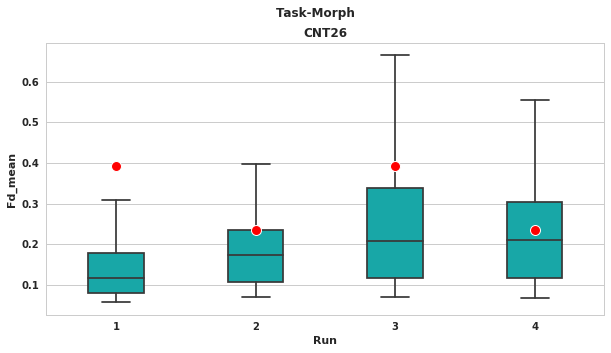

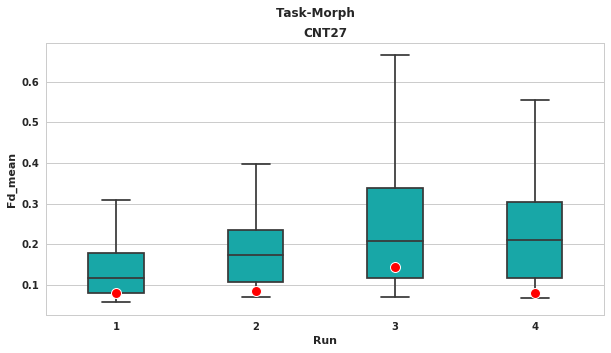

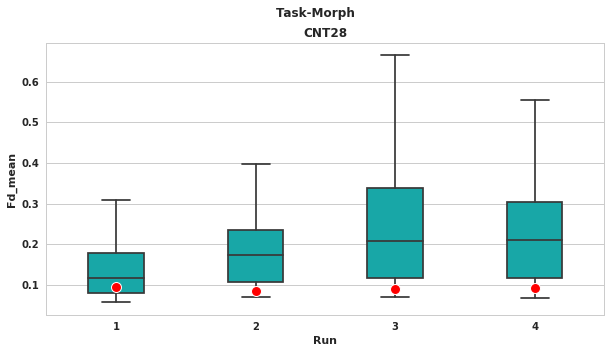

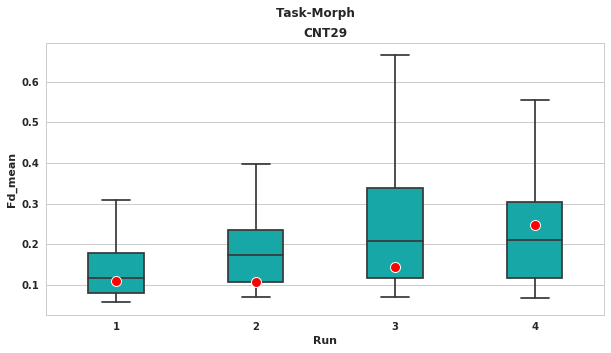

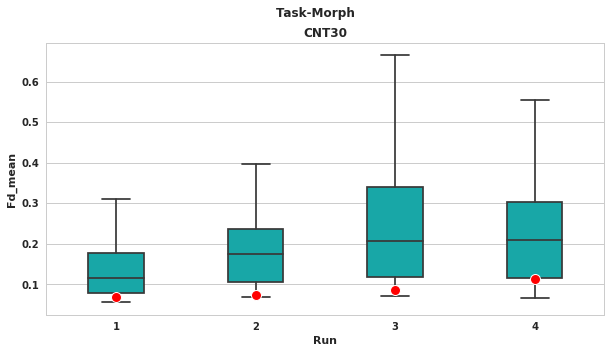

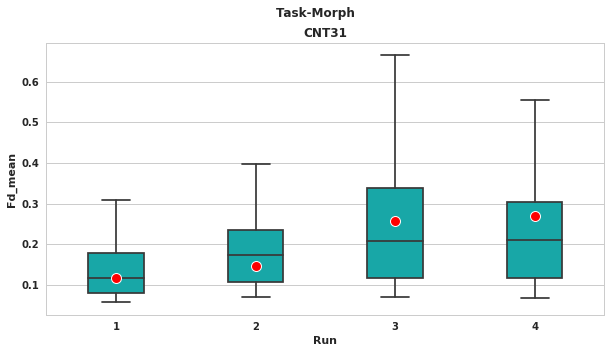

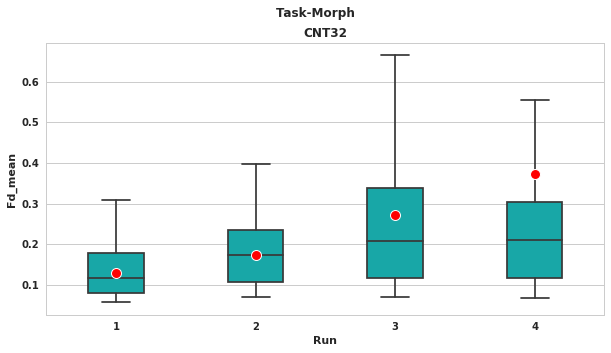

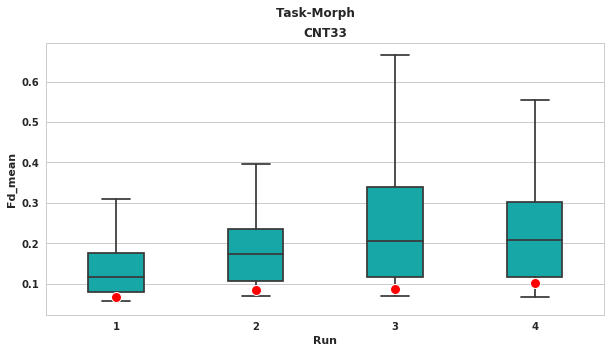

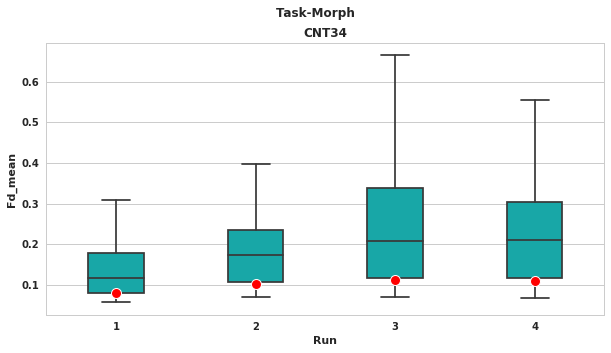

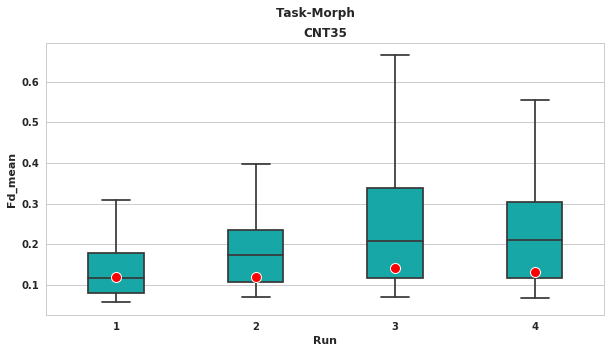

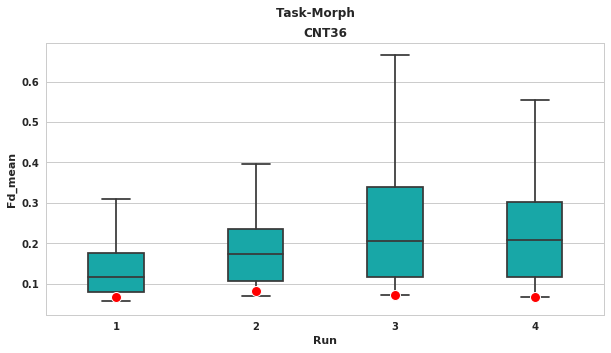

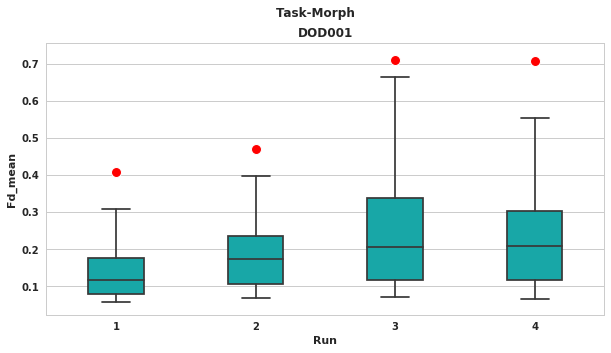

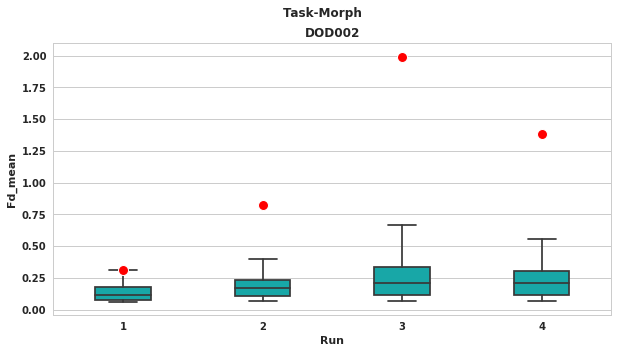

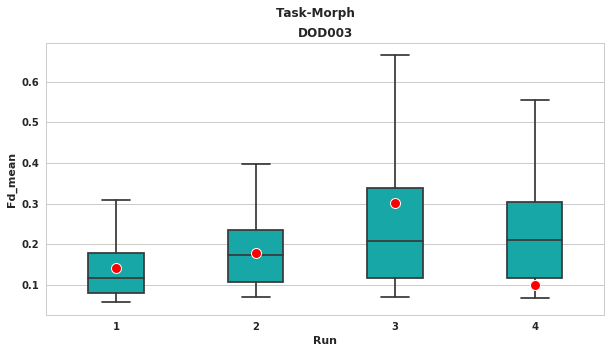

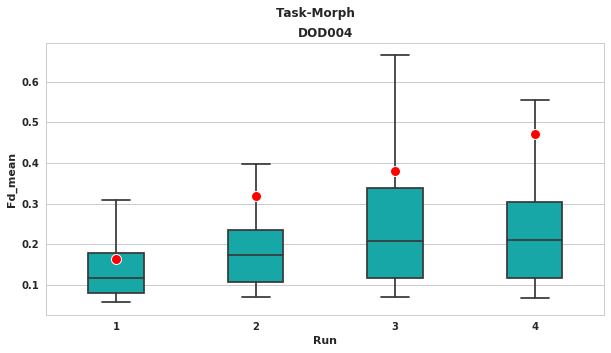

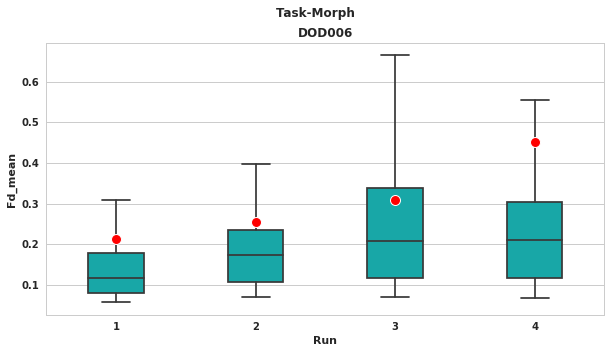

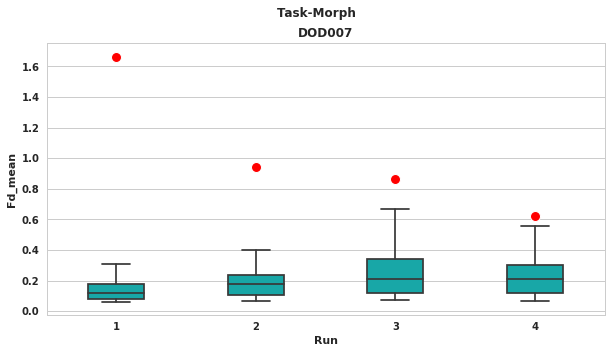

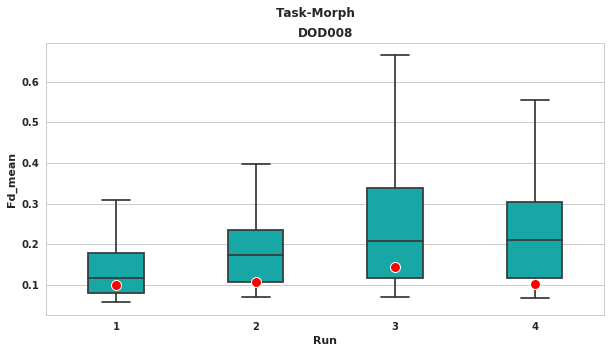

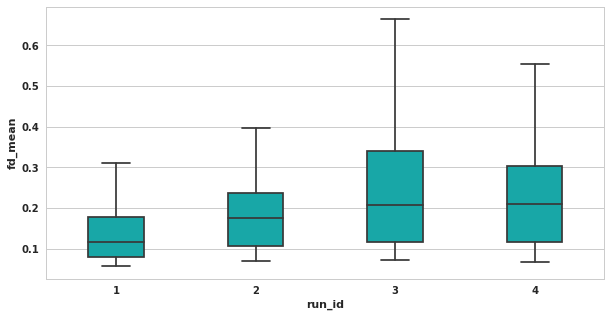

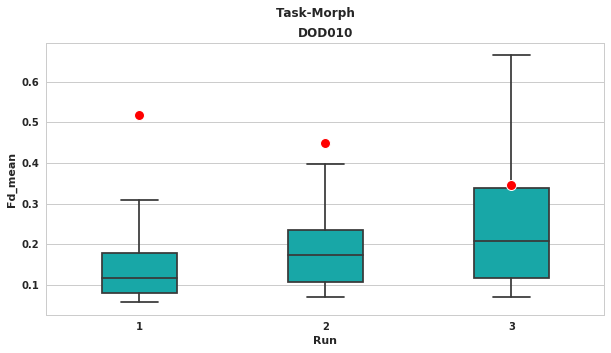

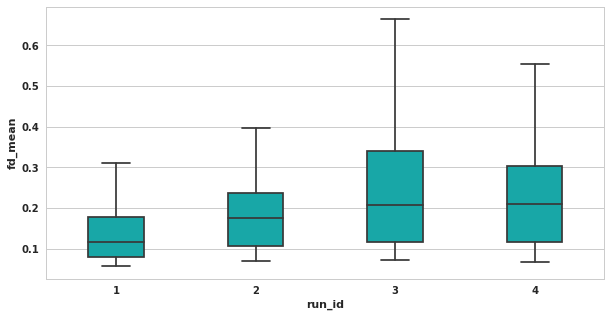

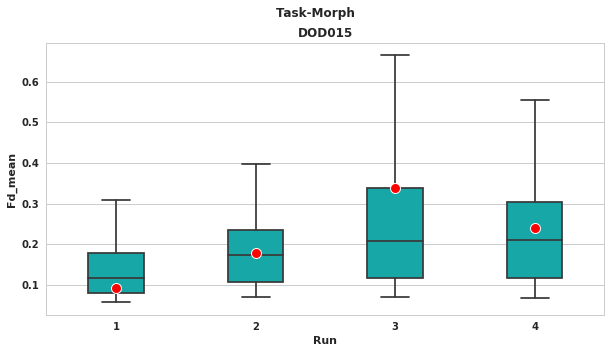

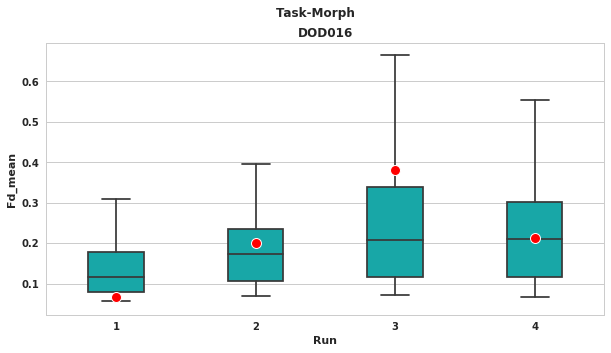

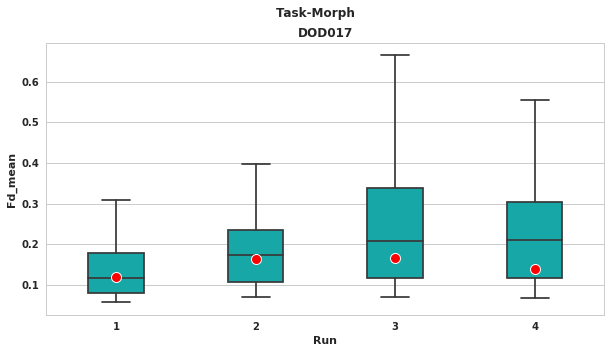

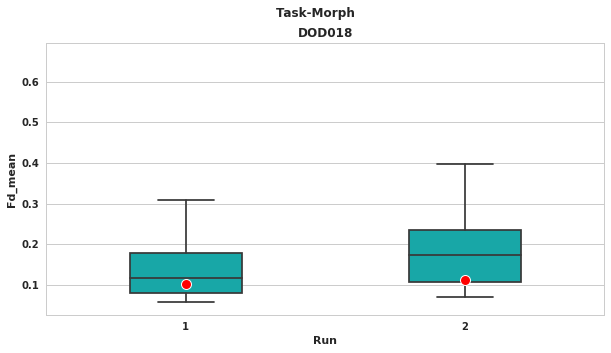

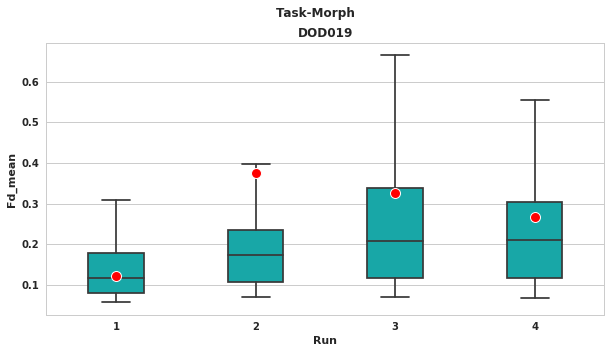

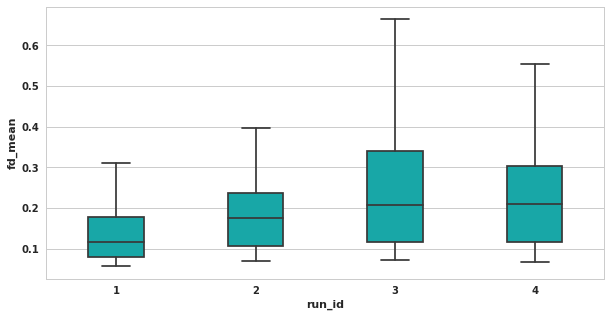

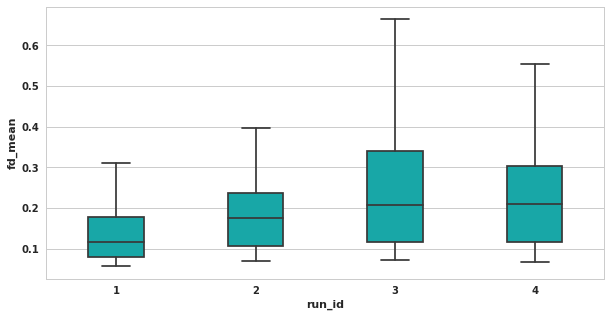

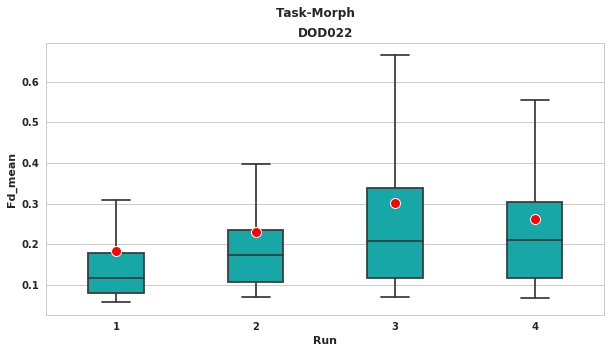

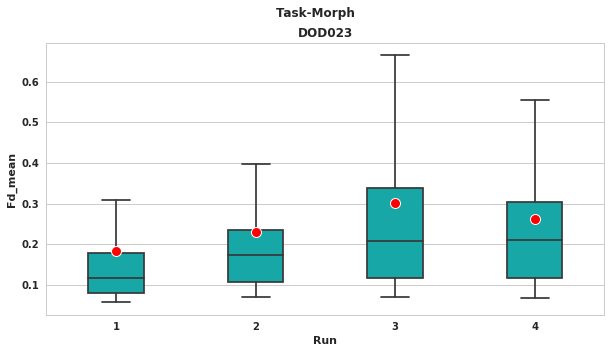

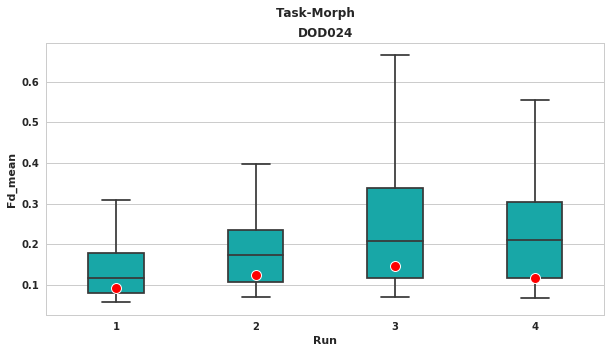

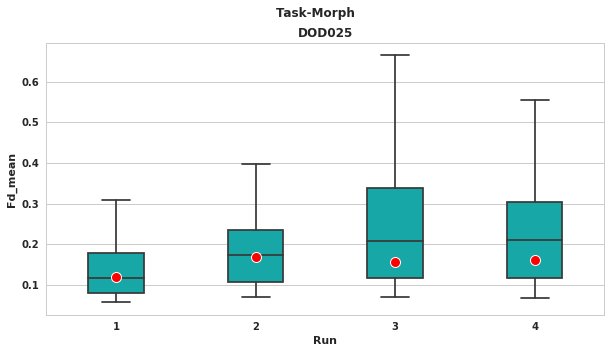

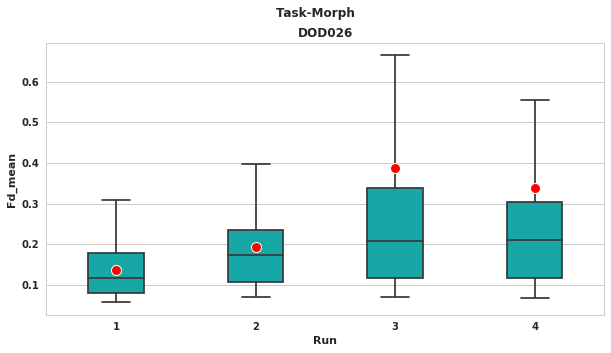

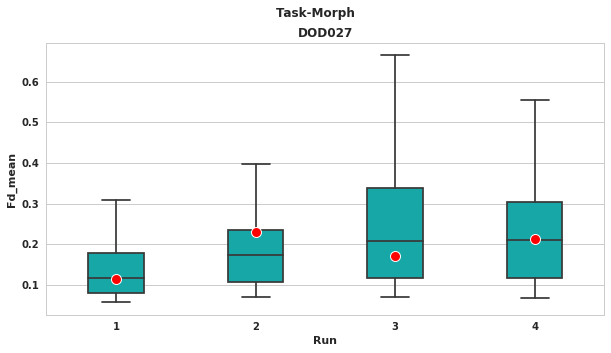

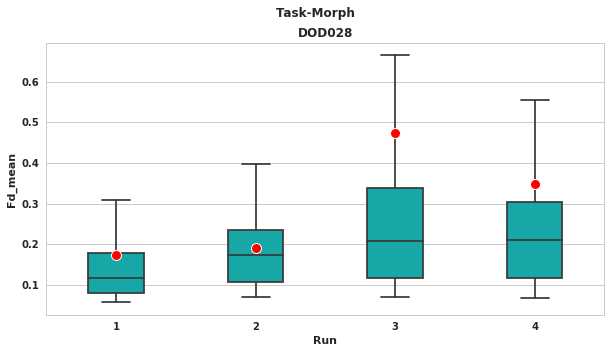

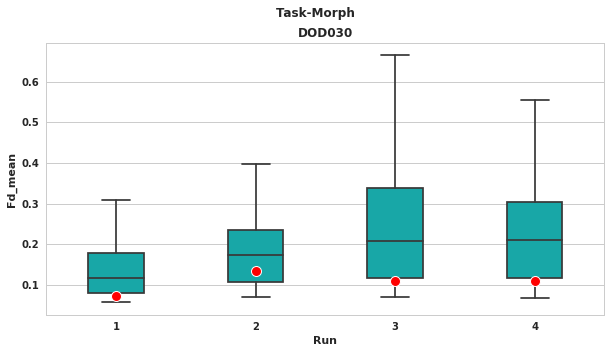

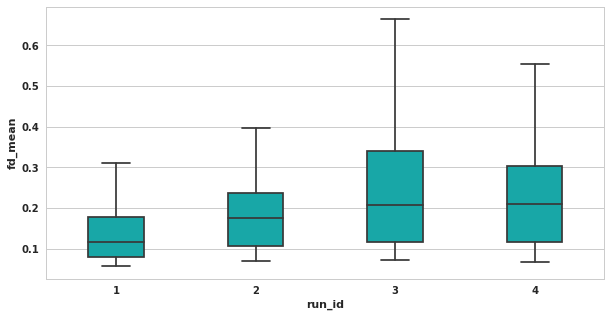

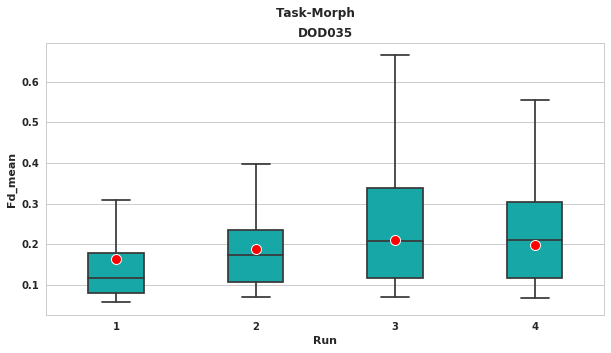

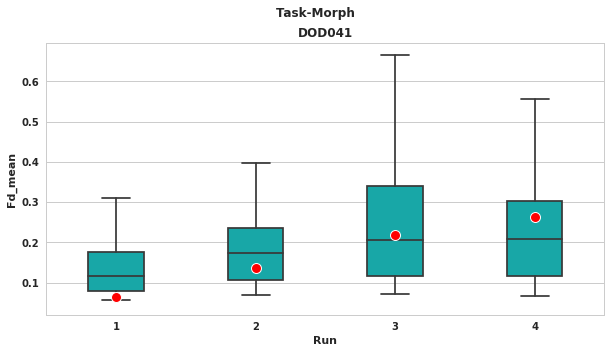

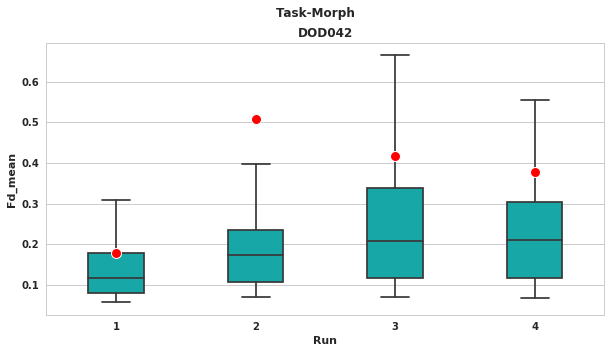

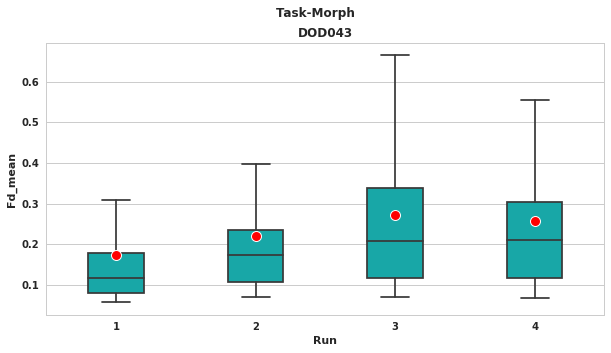

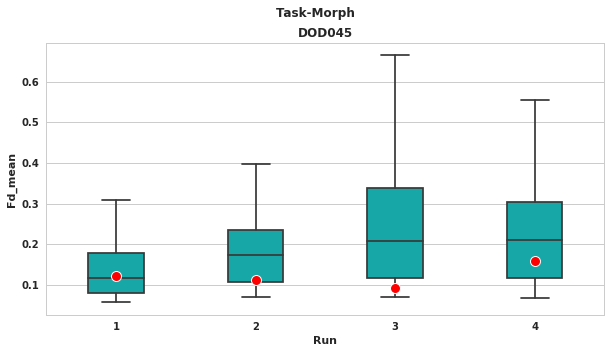

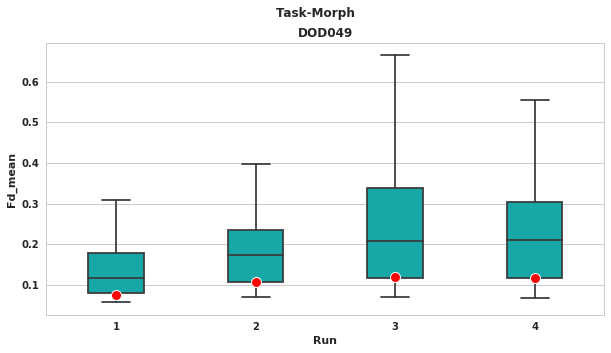

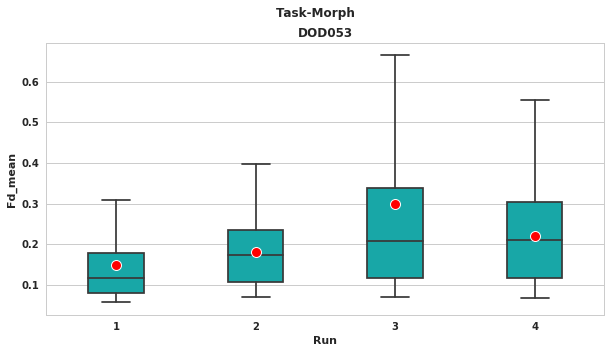

In [70]:
for subj in subjs:
    gen_single_subj_boxplots('morph', ['fd_mean'], subj)

# MRIQC out-values lookup key

## dvars
*  Temporal derivative of timecourses, VARS referring to RMS variance over voxels. indexes the rate of change of BOLD signal across the entire brain at each frame of data.

## efc
* Shannon entropy of voxel intensities as an indication of ghosting and blurring induced by head motion. Lower values are better. (The original equation is normalized by the maximum entropy, so that the EFC can be compared across images with different dimensions.)

## fber
* Mean energy of image values within the head relative to outside the head. Higher values are better.

## fd
* Expresses instantaneous head-motion. 

## fwhm
* Spatial distribution of the image intensity values in units of voxels. Lower values are better. (Uses the gaussian width estimator filter implemented in AFNI’s 3dFWHMx)

## gcor
*  Optimized summary of time-series correlation.

## gsr
* Ghost to signal ratio.

## snr
* Signal-to-noise ratio calculated within the tissue mask.

## summary_stats
* Mean, standard deviation, 5% percentile and 95% percentile of the distribution of background, CSF, GM and WM.

## tsnr
* Average BOLD signal (across time) / temporal standard-deviation map.

In [175]:
# plot median stat across all runs/tasks per subject (boxplot)
# compare to banda average
# compare to other datasets average

def compare_abide_mriqc(overlay=True):
    """ 
    Generate a boxplot with median statistic across all runs/tasks 
    per subject. Plot with the banda distribution. 
    
    XXX TODO: Add other datasets average.
    
    Parameters
    ----------
    subj : string
        The subject name (without the sub-)
    measures : list
        List of measures to plot - one plot is generated per measure.
    overlay : boolean
        If true, plot entire banda data and subject specific
        on the same axis. If false, plot in separate axes.
    """
    for measure in ['anat_cnr', 'func_mean_fd']:
        
        if overlay:
            fig, ax = plt.subplots()
            ax1, ax2 = ax, ax
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            ax2.set_xlabel("MRIQC")

        sns.set(style="whitegrid")
        
        # average normal
        sns.stripplot(x="subject", y=measure, data=abide_compare, jitter=False, 
                    color="blue", ax=ax2) # hide outliers

        ax2.set_xticklabels([])
        ax2.set_xlabel('MRIQC')
        ax2.set_ylabel('')

        ## subject specific 
        #subj_df = df.loc[df['subject_id'] == subj]
        
        sns.stripplot(x="subject", y='_'.join(['mriqc', '_'.join(measure.split('_')[1:])]), data=abide_compare, 
                    color='red', ax=ax1)

        ax1.set_ylabel(measure.upper())
        ax1.set_xlabel("")
        
    blue_patch = mpatches.Patch(color='blue', label='ABIDE processed')
    red_patch = mpatches.Patch(color='red', label='MRIQC processed')
    plt.legend(handles=[red_patch, blue_patch], ncol=1)

In [77]:
abide_compare

,subject,anat_cnr,mriqc_cnr,func_mean_fd,mriqc_mean_fd
0,50047,5.199107,3.540565,0.137113,0.192654
1,50199,21.346499,4.045258,0.023617,0.053482
2,50297,13.028323,1.548915,0.195733,0.370167
3,50336,7.149536,3.568809,0.026939,0.062741
4,50976,12.108764,4.467266,0.074607,0.128517
5,51101,14.697644,4.436864,0.091138,0.145115


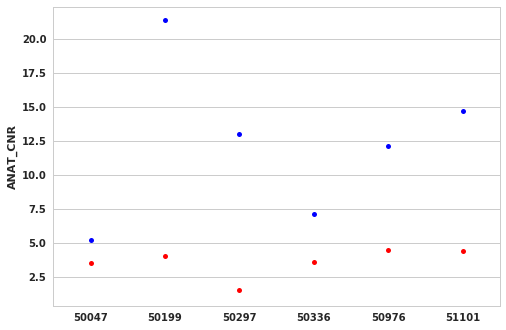

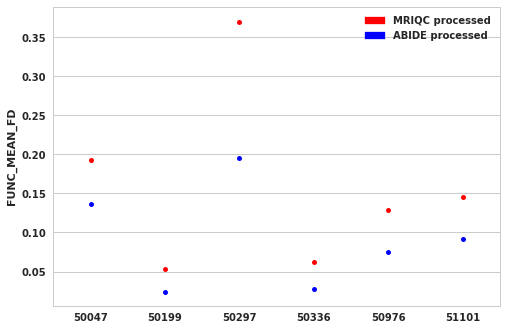

In [176]:
compare_abide_mriqc()

In [177]:
# plot median stat across all runs/tasks per subject (boxplot)
# compare to banda average
# compare to other datasets average

def boxplot_abide_mriqc(subject=None, overlay=False):
    """ 
    Generate a boxplot with median statistic across all runs/tasks 
    per subject. Plot with the banda distribution. 
    
    XXX TODO: Add other datasets average.
    
    Parameters
    ----------
    subj : string
        The subject name (without the sub-)
    measures : list
        List of measures to plot - one plot is generated per measure.
    overlay : boolean
        If true, plot entire banda data and subject specific
        on the same axis. If false, plot in separate axes.
    """
    for measure in ['anat_cnr', 'func_mean_fd']:
        
        if overlay:
            fig, ax = plt.subplots()
            ax1, ax2 = ax, ax
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            ax2.set_xlabel("MRIQC")

        sns.set(style="whitegrid")
        
        # average normal
        sns.boxplot(x=subject, y=measure, data=abide_compare, 
                    color="blue", ax=ax2, showfliers=False) # hide outliers

        ax2.set_xticklabels([])
        ax2.set_xlabel('')
        ax2.set_ylabel('')

        ## subject specific 
        #subj_df = df.loc[df['subject_id'] == subj]
        
        sns.boxplot(x=subject, y='_'.join(['mriqc', '_'.join(measure.split('_')[1:])]), data=abide_compare, 
                    color='red', ax=ax1, showfliers=False)

        ax1.set_ylabel(measure.upper())
        ax1.set_xlabel("")
        
    blue_patch = mpatches.Patch(color='blue', label='ABIDE processed')
    red_patch = mpatches.Patch(color='red', label='MRIQC processed')
    
    plt.legend(handles=[red_patch, blue_patch], loc=(-1, 1.2), ncol=2)

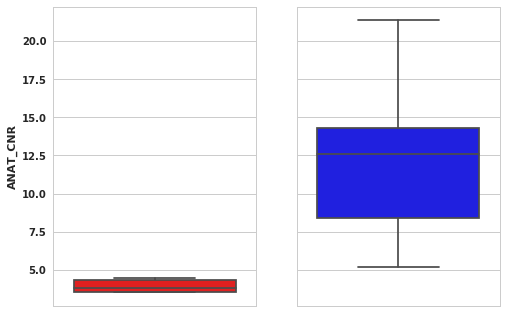

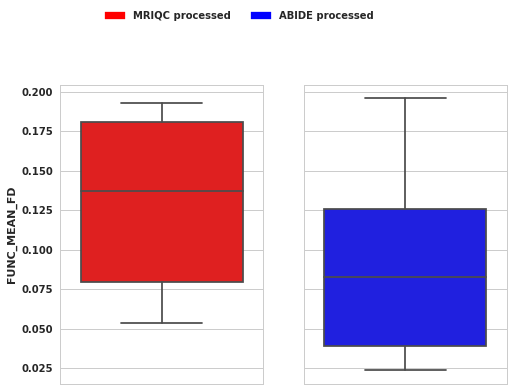

In [182]:
boxplot_abide_mriqc()

In [179]:
abide_compare

,subject,anat_cnr,mriqc_cnr,func_mean_fd,mriqc_mean_fd
0,50047,5.199107,3.540565,0.137113,0.192654
1,50199,21.346499,4.045258,0.023617,0.053482
2,50297,13.028323,1.548915,0.195733,0.370167
3,50336,7.149536,3.568809,0.026939,0.062741
4,50976,12.108764,4.467266,0.074607,0.128517
5,51101,14.697644,4.436864,0.091138,0.145115


In [44]:
import shutil
def grab_carpet_plots(wrkdir=None, savedir=None, save=False):
    if not wrkdir: 
        wrkdir = ('/om/project/autoxy/processedData/bids/workdir/mathias/'
                  'qa_workdir/workflow_enumerator/funcMRIQC/ReportsWorkflow/')
    if not savedir:
        savedir = '/om/project/autoxy/processedData/bids/data/derivatives/mriqc/carpet_plots'

    for func in os.listdir(wrkdir):
        pltdir = os.path.join(wrkdir, func, 'BigPlot')
        plot = [x for x in os.listdir(pltdir) if x.endswith('.svg')][0]
        plot2 = '_'.join(plot.split('_')[:3]) + '_carpetplot.svg'
        
        if save:
            shutil.copy(os.path.join(pltdir, plot), os.path.join(savedir, plot2))

In [63]:
def display_carpet_plots(subj):
    pltdir = '/om/project/autoxy/processedData/bids/data/derivatives/mriqc/carpet_plots'
    for plot in sorted(os.listdir(pltdir)):
        if subj in plot:
            print(plot)
            display(SVG(os.path.join(pltdir, plot)))

In [4]:
def gen_pairplot_df(measure='fd_mean'):
    mr1 = df_func[(df_func.task_id == 'morph') & (df_func.run_id == 1)]
    mr2 = df_func[(df_func.task_id == 'morph') & (df_func.run_id == 2)]
    mr3 = df_func[(df_func.task_id == 'morph') & (df_func.run_id == 3)]
    mr4 = df_func[(df_func.task_id == 'morph') & (df_func.run_id == 4)]
    r1 = df_func[(df_func.task_id == 'rest') & (df_func.run_id == 1)]
    
    pp_df = pd.DataFrame(columns=['subject_id', 'group', 'rest', 
                                  'morph1', 'morph2', 'morph3', 
                                  'morph4', 'morph-avg'])
    
    for subj in subjs:
        # in case returned df is blank
        cleaner = lambda x: x.item() if len(x) != 0 else np.nan
        
        if subj.startswith('CNT'):
            group = 'CNT'
        else:
            group = 'ASD'
        
        subj_morph = gen_subject_df(df_func, subj, task='morph')
        
        subj_info = {
                     'subject_id': subj,
                     'group' : group,
                     'rest': cleaner(r1[r1.subject_id == subj][measure]),
                     'morph1': cleaner(mr1[mr1.subject_id == subj][measure]),
                     'morph2': cleaner(mr2[mr2.subject_id == subj][measure]),
                     'morph3': cleaner(mr3[mr3.subject_id == subj][measure]),
                     'morph4': cleaner(mr4[mr4.subject_id == subj][measure]),
                     'morph-avg': subj_morph[measure].mean()
                    }
        pp_df = pp_df.append(subj_info, ignore_index=True)
        
    return pp_df

In [39]:
def pairgrid_dotplot(measure='fd_mean', cutoff=.3, cntbp=False, outdir=None):
    """ TODO: return subjects + number of runs (excluding mean) that are over cutoff """

    pp_df = gen_pairplot_df(measure)
    stats = pp_df.columns[2:]
    
    sns.set(style='whitegrid')
    fig, (topaxes, botaxes) = plt.subplots(2, len(stats), sharex=True, figsize=(15,22),
                                           gridspec_kw = {'height_ratios':[7,1]}) 
    
    # top axes will make scatter plot
    for stat, ax in zip(stats, topaxes):
        sns.stripplot(y='subject_id', x=stat, hue='group', 
                      data=pp_df, size=7, ax=ax)
        
        ax.axvline(x=cutoff, linestyle='--', color='black')
        
        if ax != topaxes[0]:
            ax.set(ylabel="", yticklabels=[""])
            ax.legend_.remove()
        else:
            ax.set_ylabel("Subject", fontsize=20)
            ax.legend(bbox_to_anchor=(-0.65, 1.02), loc=2, 
                      borderaxespad=0.)
            
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        
        ax.set(xlim=(0, 0.8), title=stat.capitalize(), xlabel="")
        
    # bottom axes will make box plot
    
    color = 'gray'
    if cntbp:
        pp_df = pp_df[pp_df.group == 'CNT']
        color = None
    
    for stat, ax in zip(stats, botaxes):
        sns.boxplot(x=stat, data=pp_df, ax=ax, showfliers=False, 
                    color=color, width=.3)
        
        ax.axvline(x=cutoff, linestyle='--', color='black')
        
        ax.xaxis.grid(False)
        ax.set(xlabel=stat.capitalize())
        
        if ax == botaxes[0]:
            ax.set_ylabel('All')
        
    fig.text(0.53, -0.01, measure.upper(), ha='center', size='large')
    plt.setp((topaxes, botaxes), xticks=[0.2, 0.4, 0.6, 0.8])
    plt.tight_layout()
    
    if outdir:
        outfile = os.path.abspath(os.path.join(outdir, 'fd_across_functionals.png'))
        plt.savefig(outfile)

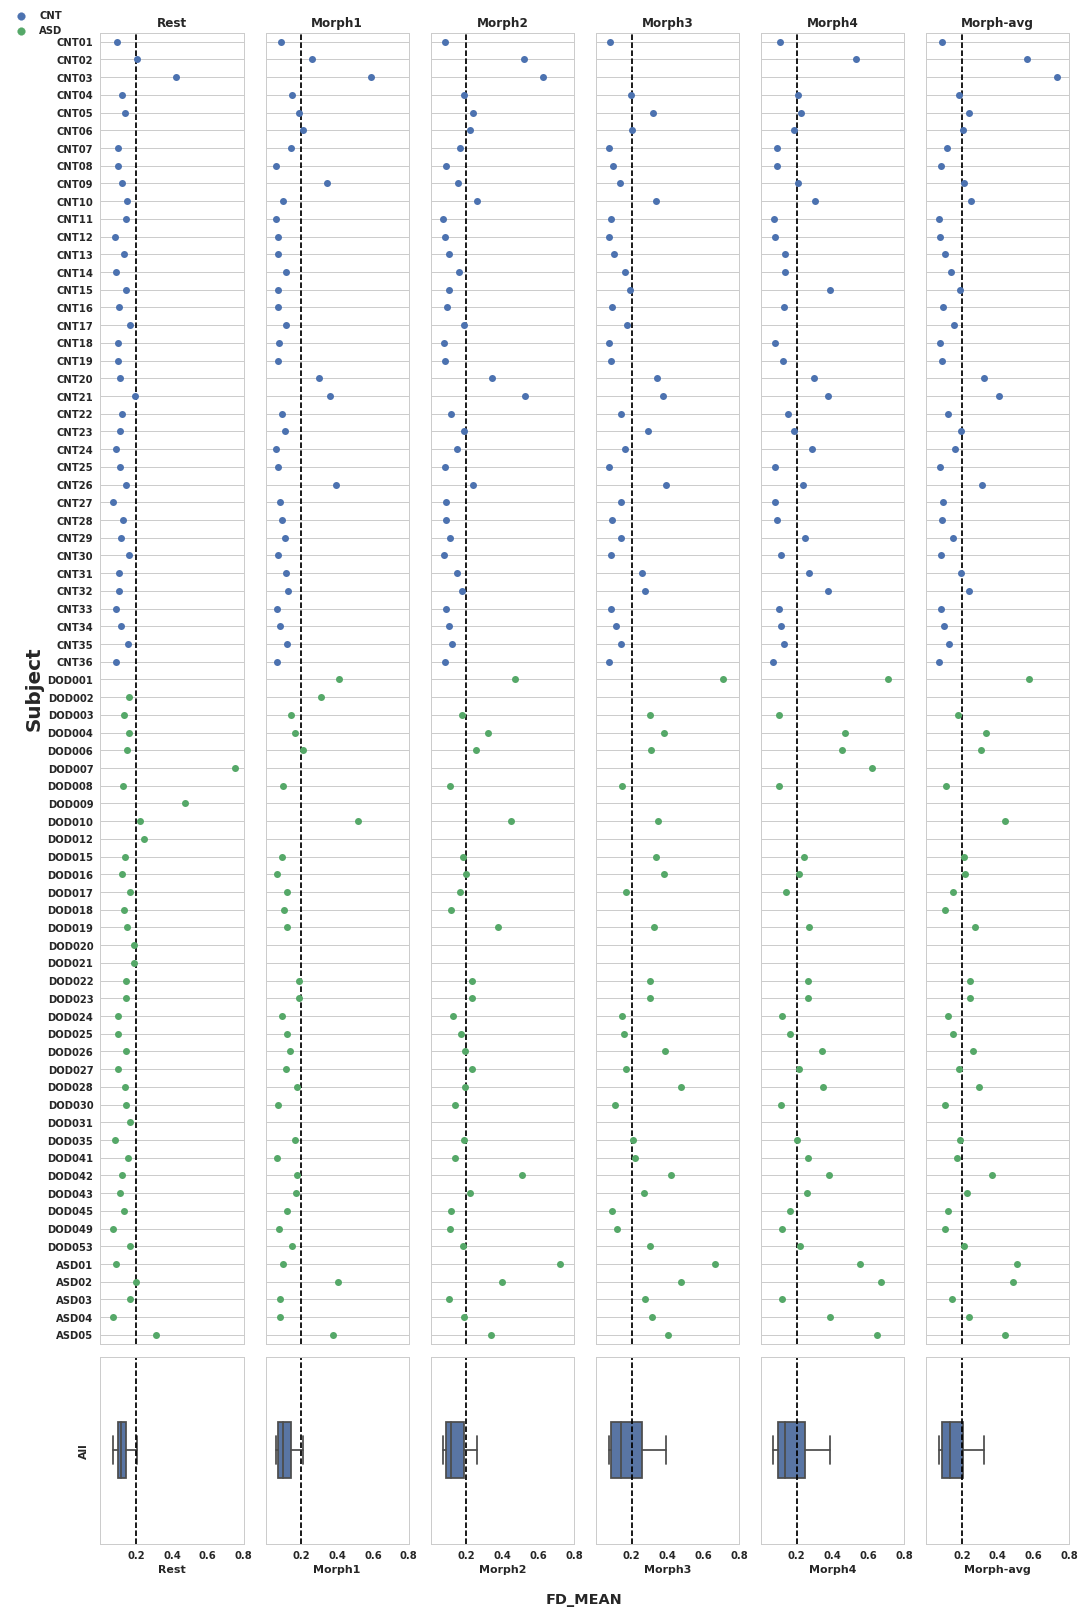

In [40]:
pairgrid_dotplot(cutoff=.2, cntbp=True, outdir='.')